**Surrogate Modeling of MODTRAN RTM**
/ by: Mohammad Aghdami-Nia

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
import pickle
from tqdm import tqdm_notebook
import glob

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPool1D, Conv1DTranspose, Concatenate, Input
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from keras import backend as K
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!du -sh /content/gdrive/MyDrive/*

1.5K	/content/gdrive/MyDrive/5-grid search.npy
59M	/content/gdrive/MyDrive/antar.rar
5.2G	/content/gdrive/MyDrive/change detection
43K	/content/gdrive/MyDrive/Colab Notebooks
3.7M	/content/gdrive/MyDrive/Copy of Classification2.ipynb
16K	/content/gdrive/MyDrive/Copy of Keras Fashion MNIST.ipynb
44K	/content/gdrive/MyDrive/Copy of U-Net.ipynb
208K	/content/gdrive/MyDrive/CV (1).pdf
208K	/content/gdrive/MyDrive/CV.pdf
1.2M	/content/gdrive/MyDrive/DLA_S7.ipynb
34M	/content/gdrive/MyDrive/MohammadAghdamiNia_MSc Thesis (1).doc
32M	/content/gdrive/MyDrive/MohammadAghdamiNia_MSc Thesis (2).doc
34M	/content/gdrive/MyDrive/MohammadAghdamiNia_MSc Thesis.doc
826K	/content/gdrive/MyDrive/MSc transcripts.pdf
115M	/content/gdrive/MyDrive/planetry
0	/content/gdrive/MyDrive/project
0	/content/gdrive/MyDrive/sea ice data
1.6G	/content/gdrive/MyDrive/thesis
0	/content/gdrive/MyDrive/U-Net
30M	/content/gdrive/MyDrive/تمپلیت نگارش و تدوین پایان نامه (1).doc


In [4]:
def calc_angle(v1, v2):
  dot_p = np.dot(v1, v2)
  norm_p = np.linalg.norm(v1) * np.linalg.norm(v2)
  angle = np.arccos(dot_p / norm_p)
  return np.degrees(angle)

def calc_metrics(mat1, mat2):
  angles, rmse, r2 = [], [], []
  for elm1, elm2 in zip(mat1, mat2):
      angles.append(calc_angle(elm1, elm2))
      rmse.append(np.sqrt(metrics.mean_squared_error(elm1, elm2)))
      r2.append(metrics.r2_score(elm1, elm2))
  return np.array(angles), np.array(rmse), np.array(r2)

# BSCN

## load data

In [5]:
input_data = np.load('/content/gdrive/MyDrive/thesis/data/BSCN_input_data.npy')
output_data = np.load('/content/gdrive/MyDrive/thesis/data/BSCN_output_data.npy')
params_data = np.load('/content/gdrive/MyDrive/thesis/data/BSCN_params_data.npy')

In [6]:
print(input_data.shape, output_data.shape, params_data.shape)
print(input_data.min(), output_data.min())
print(input_data.max(), output_data.max())

(2045, 61) (2045, 61) (2045, 12)
0.0196 0.0438
0.4103 0.3982


In [7]:
input_data = np.zeros((2045, 210)).astype('float32')
input_data[:, :61] = np.load('/content/gdrive/MyDrive/thesis/data/BSCN_input_data.npy')

output_data = np.zeros((2045, 210)).astype('float32')
output_data[:, :61] = np.load('/content/gdrive/MyDrive/thesis/data/BSCN_output_data.npy')

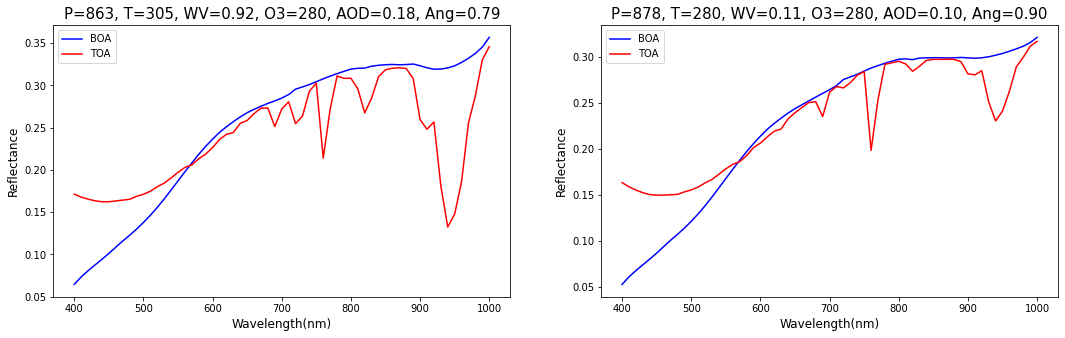

In [8]:
bands = np.arange(400, 1010, 10)
inds = np.random.randint(input_data.shape[0], size=2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
for ind, ax in zip(inds, axs.ravel()):
  ax.plot(bands, input_data[ind, :61], 'b-', label='BOA')
  ax.plot(bands, output_data[ind, :61], '-', color='red', label='TOA')
  ax.set_title('P={:.0f}, T={:.0f}, WV={:.2f}, O3={:.0f}, AOD={:.2f}, Ang={:.2f}'.format(params_data[ind, 2], params_data[ind, 3], params_data[ind, 4], params_data[ind, 5], params_data[ind, 6], params_data[ind, 7])
  , fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['BOA', 'TOA'])
plt.savefig('/content/gdrive/MyDrive/thesis/plots/BSCN2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

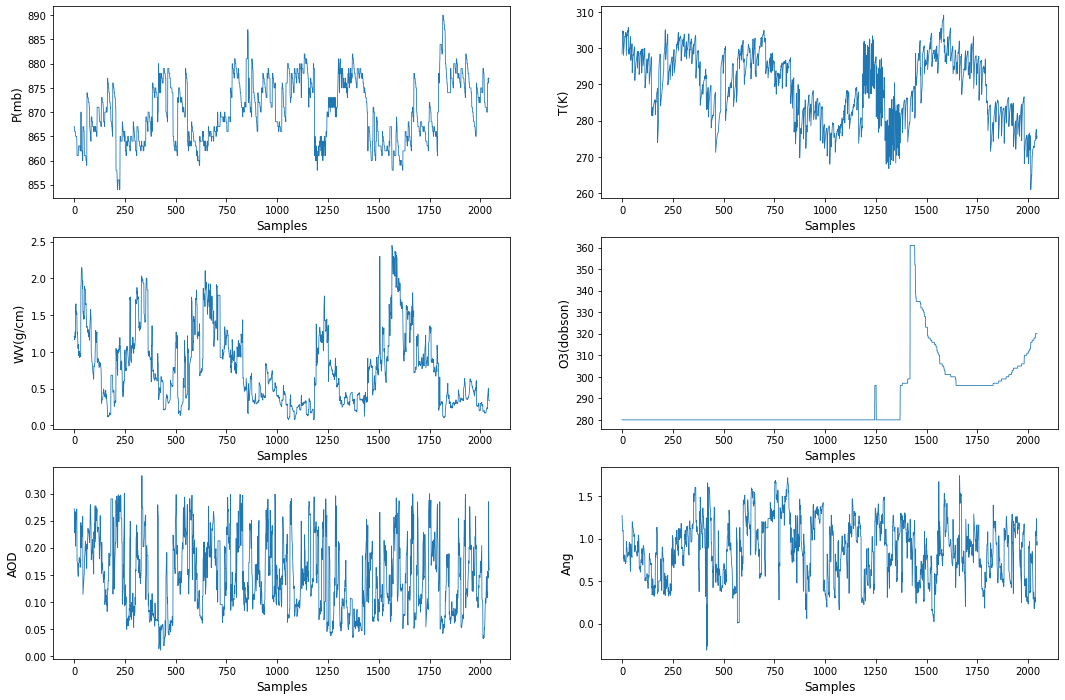

In [9]:
plot_names = ['day', 'time', 'P(mb)', 'T(K)', 'WV(g/cm)', 'O3(dobson)', 'AOD', 'Ang', 'Type', 'Zen', 'Azi', 'esd']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for i, ax in zip(range(2, 8), axs.ravel()):
  ax.plot(params_data[:, i], linewidth=0.8)
  ax.set_xlabel('Samples', fontsize=12)
  ax.set_ylabel(plot_names[i], fontsize=12)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/BSCN1.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

## normalize

In [10]:
# params_data = np.delete(params_data, 8, axis=1)
# plot_names.pop(8)
params_data[0, 8] = 0
params_data[1:, 8] = 1

params_min = params_data.min(axis=0)
params_max = params_data.max(axis=0)
params_scaled = (params_data - params_min) / (params_max - params_min)

params_scaled[0, 8] = 1

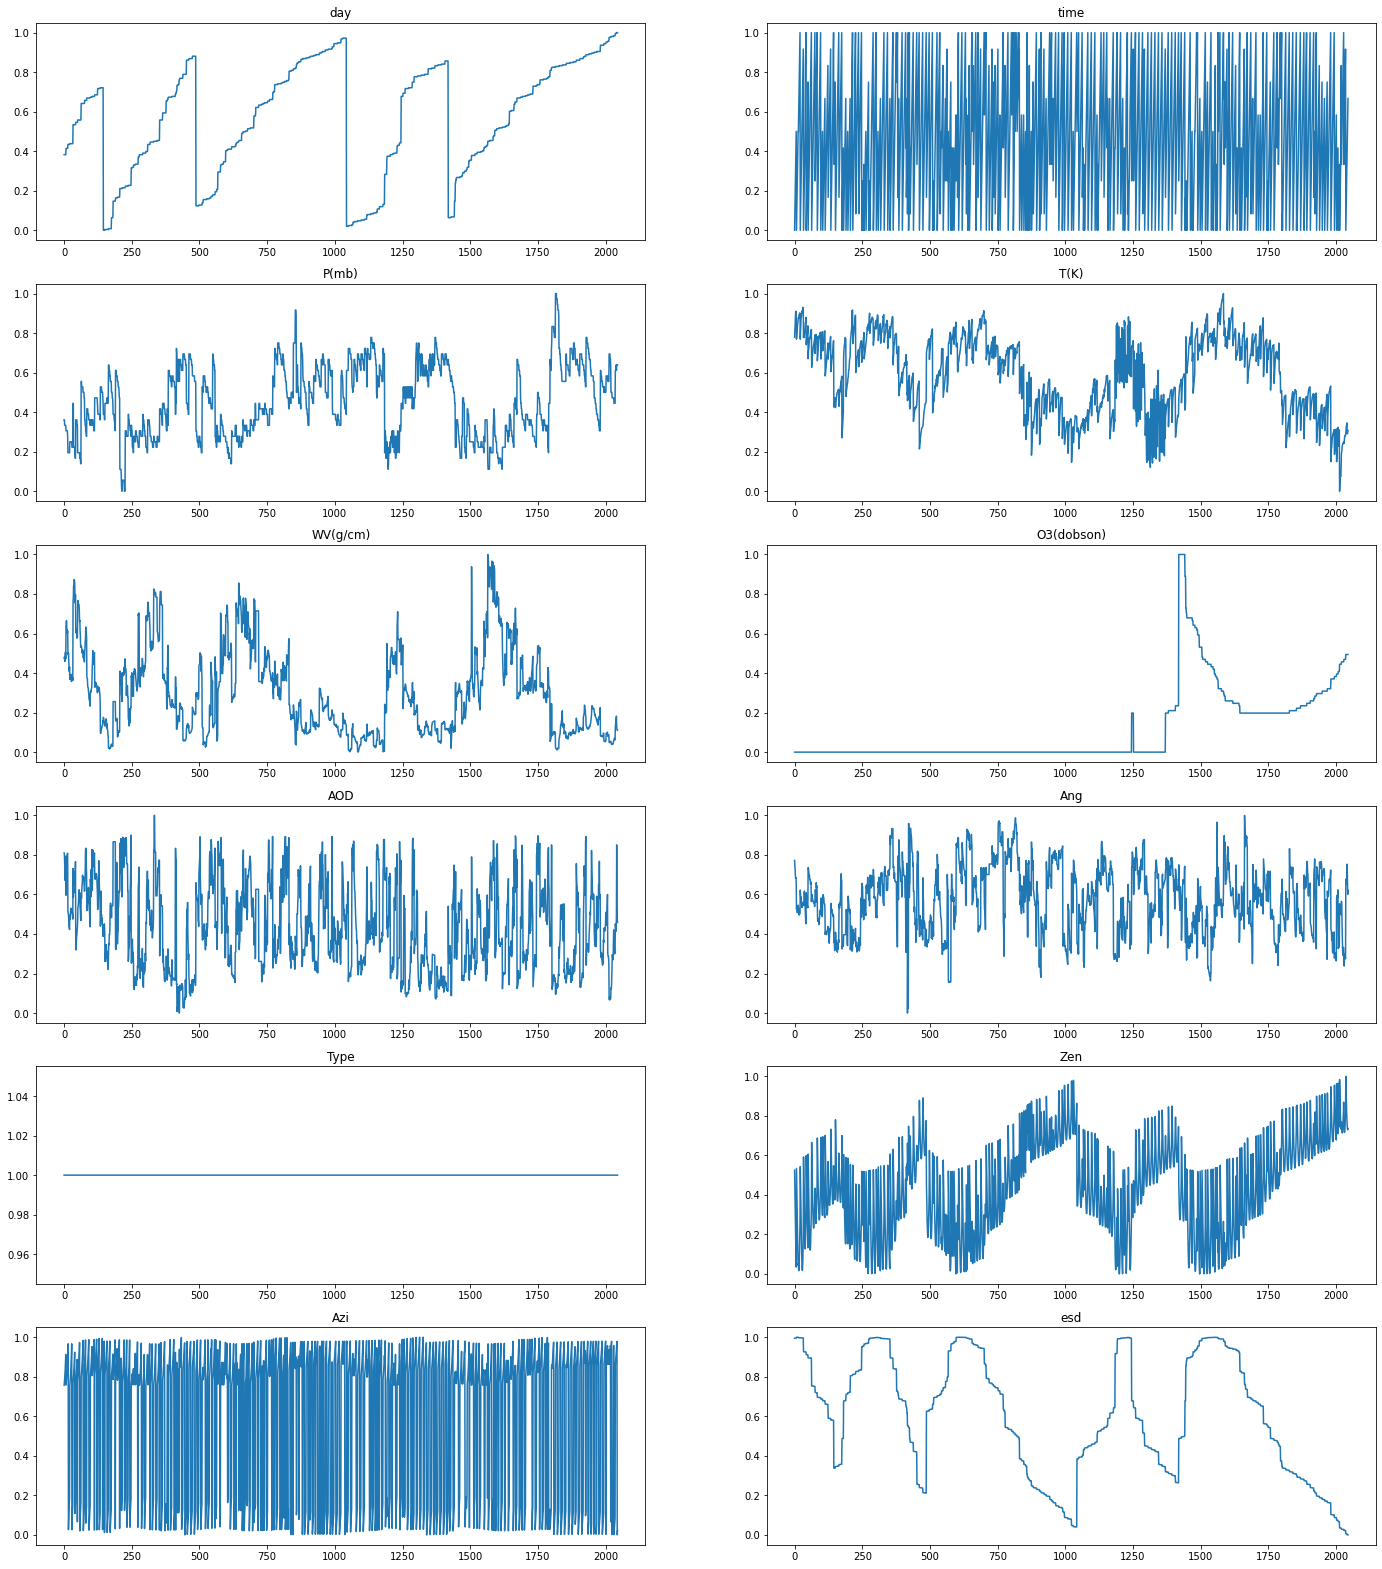

In [11]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axs.ravel()):
  # if i==11:
  #   break
  ax.plot(params_scaled[:, i])
  ax.set_title(plot_names[i])
plt.show()

## seperate test & train

In [12]:
X = np.concatenate([params_scaled, input_data], axis=1)
# X = np.concatenate([params_data, input_data], axis=1)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, output_data, test_size=0.3, random_state=9)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(2045, 222)
(1431, 222) (614, 222)
(1431, 210) (614, 210)


## fc-net

In [ ]:
fc_net = Sequential()
fc_net.add(Dense(210, activation='relu', input_shape=(222, )))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(12, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(210, activation='linear'))

fc_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
fc_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 210)               46830     
                                                                 
 dense_10 (Dense)            (None, 105)               22155     
                                                                 
 dense_11 (Dense)            (None, 60)                6360      
                                                                 
 dense_12 (Dense)            (None, 25)                1525      
                                                                 
 dense_13 (Dense)            (None, 12)                312       
                                                                 
 dense_14 (Dense)            (None, 25)                325       
                                                                 
 dense_15 (Dense)            (None, 60)               

### result

In [13]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BSCN/fcn.h5'
fc_net = load_model(checkpoint_path, compile=False)
result = fc_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

20/20 [==============================] - 1s 4ms/step
mean angle:  2.7602127
mean rmse:  0.010749013
mean r2:  0.9221609376002092


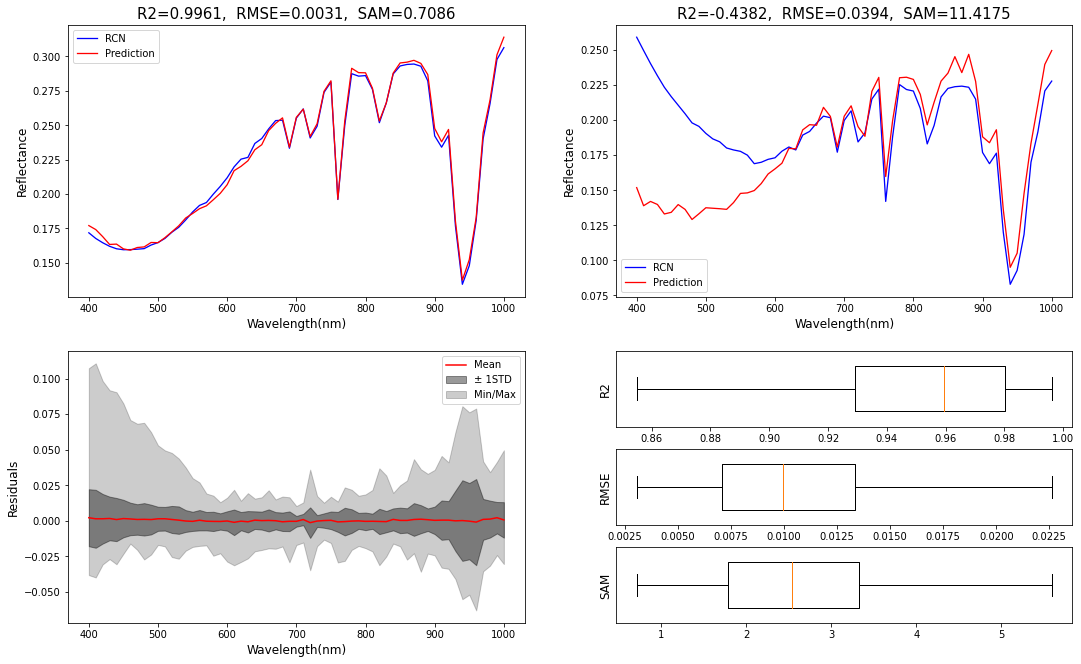

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BSCN-FC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net

In [ ]:
def build_conv_net(input_shape):
  input_1 = Input(input_shape)

  x = Conv1D(filters=8, kernel_size=3)(input_1)
  x = Activation("relu")(x)
  x = Conv1D(filters=8, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=16, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=32, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=64, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=64, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=32, kernel_size=4, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=16, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=8, kernel_size=2, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=8, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model(input_1, x)
  return model

conv_net = build_conv_net((222, 1))
conv_net.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
conv_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 222, 1)]          0         
                                                                 
 conv1d_30 (Conv1D)          (None, 220, 8)            32        
                                                                 
 activation_36 (Activation)  (None, 220, 8)            0         
                                                                 
 conv1d_31 (Conv1D)          (None, 220, 8)            200       
                                                                 
 activation_37 (Activation)  (None, 220, 8)            0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 110, 8)           0         
 1D)                                                             
                                                           

### result

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BSCN/cnn.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

20/20 [==============================] - 1s 10ms/step
mean angle:  2.430807
mean rmse:  0.010199435
mean r2:  0.936584662110788


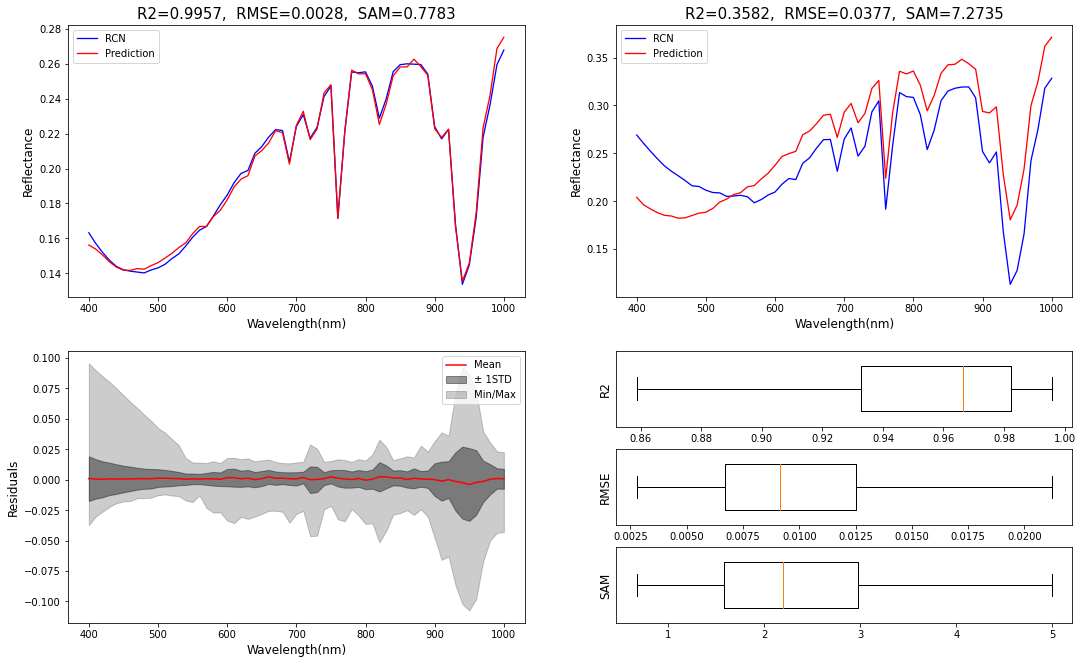

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BSCN-CNN.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net bottleneck

In [ ]:
def build_conv_net_bn(input_shape1, input_shape2):
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)

  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)

  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(input_2)
  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  x = Concatenate()([x, y])

  x = Conv1DTranspose(filters=64, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=32, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=16, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=8, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model([input_1, input_2], x)
  return model

conv_net_bn = build_conv_net_bn((210, 1), (12, 1))
conv_net_bn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
conv_net_bn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 210, 1)]     0           []                               
                                                                                                  
 conv1d_64 (Conv1D)             (None, 208, 8)       32          ['input_6[0][0]']                
                                                                                                  
 conv1d_65 (Conv1D)             (None, 208, 8)       200         ['conv1d_64[0][0]']              
                                                                                                  
 max_pooling1d_16 (MaxPooling1D  (None, 104, 8)      0           ['conv1d_65[0][0]']              
 )                                                                                          

### result

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BSCN/ae.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict([x_test[:, 12:], x_test[:, :12]])
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

20/20 [==============================] - 1s 11ms/step
mean angle:  1.6423774
mean rmse:  0.0066836416
mean r2:  0.9686303221241584


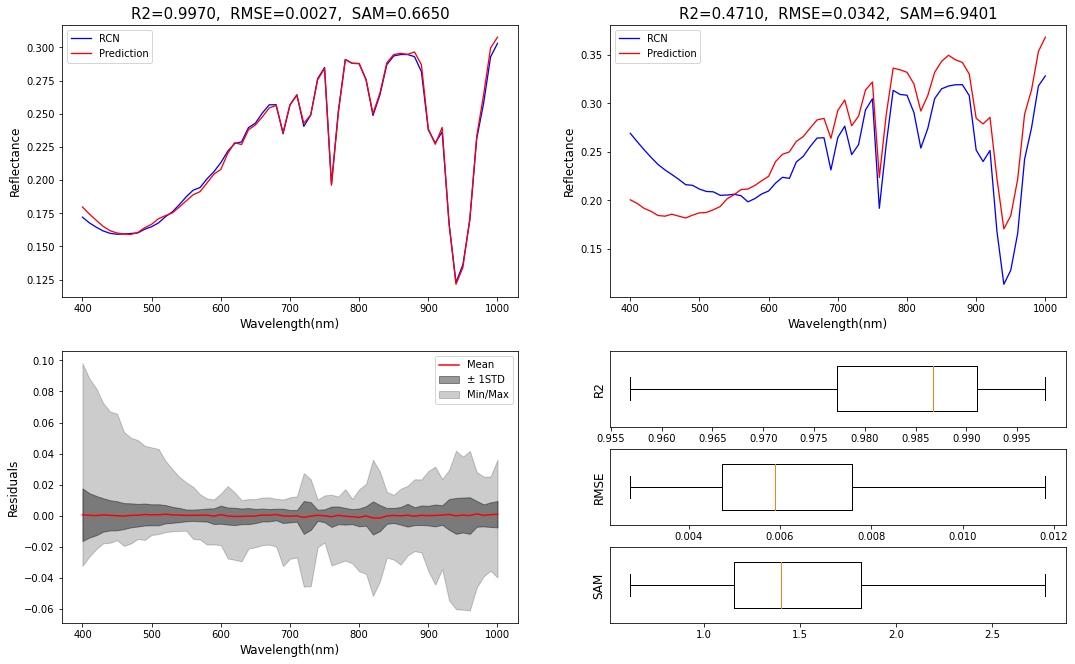

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BSCN-AE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## random forest

### result

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BSCN/rf.pkl'
with open(checkpoint_path, 'rb') as pickle_file:
  rf = pickle.load(pickle_file)

result = rf.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

mean angle:  2.4651407410176587
mean rmse:  0.013019846709816913
mean r2:  0.888622912756712


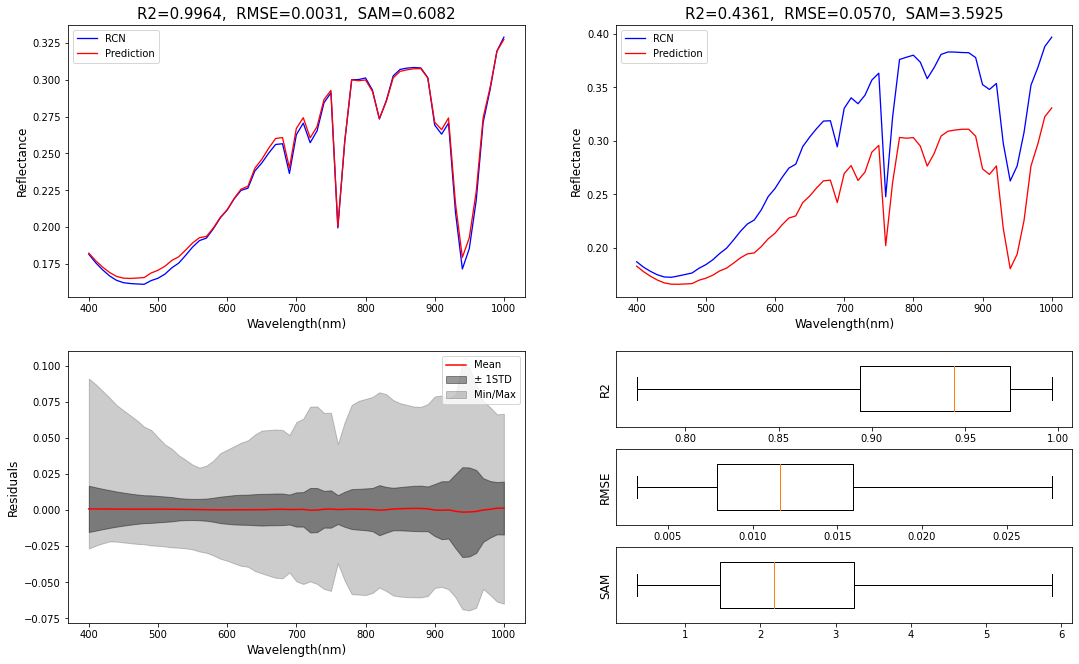

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BSCN-RF.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# BTCN

## load data

In [14]:
input_data = np.load('/content/gdrive/MyDrive/thesis/data/BTCN_input_data.npy')
output_data = np.load('/content/gdrive/MyDrive/thesis/data/BTCN_output_data.npy')
params_data = np.load('/content/gdrive/MyDrive/thesis/data/BTCN_params_data.npy')

In [15]:
print(input_data.shape, output_data.shape, params_data.shape)
print(input_data.min(), output_data.min())
print(input_data.max(), output_data.max())

(3449, 61) (3449, 61) (3449, 12)
0.0516 0.0356
0.2648 0.293


In [16]:
input_data = np.zeros((3449, 210)).astype('float32')
input_data[:, :61] = np.load('/content/gdrive/MyDrive/thesis/data/BTCN_input_data.npy')

output_data = np.zeros((3449, 210)).astype('float32')
output_data[:, :61] = np.load('/content/gdrive/MyDrive/thesis/data/BTCN_output_data.npy')

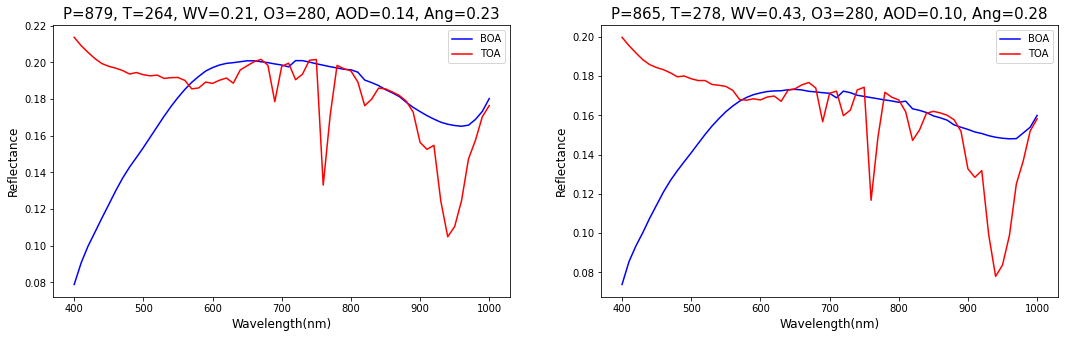

In [17]:
bands = np.arange(400, 1010, 10)
inds = np.random.randint(input_data.shape[0], size=2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
for ind, ax in zip(inds, axs.ravel()):
  ax.plot(bands, input_data[ind, :61], 'b-', label='BOA')
  ax.plot(bands, output_data[ind, :61], '-', color='red', label='TOA')
  ax.set_title('P={:.0f}, T={:.0f}, WV={:.2f}, O3={:.0f}, AOD={:.2f}, Ang={:.2f}'.format(params_data[ind, 2], params_data[ind, 3], params_data[ind, 4], params_data[ind, 5], params_data[ind, 6], params_data[ind, 7])
  , fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['BOA', 'TOA'])
plt.savefig('/content/gdrive/MyDrive/thesis/plots/BTCN2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

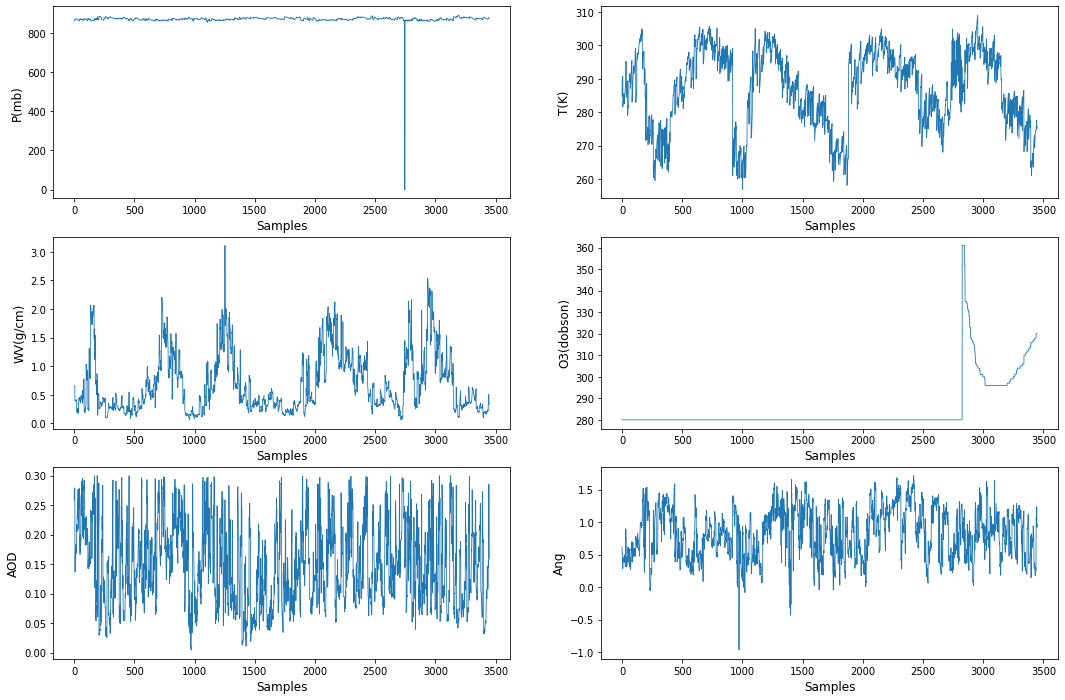

In [18]:
plot_names = ['day', 'time', 'P(mb)', 'T(K)', 'WV(g/cm)', 'O3(dobson)', 'AOD', 'Ang', 'Type', 'Zen', 'Azi', 'esd']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for i, ax in zip(range(2, 8), axs.ravel()):
  ax.plot(params_data[:, i], linewidth=0.8)
  ax.set_xlabel('Samples', fontsize=12)
  ax.set_ylabel(plot_names[i], fontsize=12)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/BTCN1.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

## normalize

In [19]:
params_data = np.delete(params_data, [2745, 2746, 2747, 2748], axis=0)
input_data = np.delete(input_data, [2745, 2746, 2747, 2748], axis=0)
output_data = np.delete(output_data, [2745, 2746, 2747, 2748], axis=0)

# params_data = np.delete(params_data, 8, axis=1)
# plot_names.pop(8)
params_data[0, 8] = 0
params_data[1:, 8] = 1

params_min = params_data.min(axis=0)
params_max = params_data.max(axis=0)
params_scaled = (params_data - params_min) / (params_max - params_min)

params_scaled[0, 8] = 1

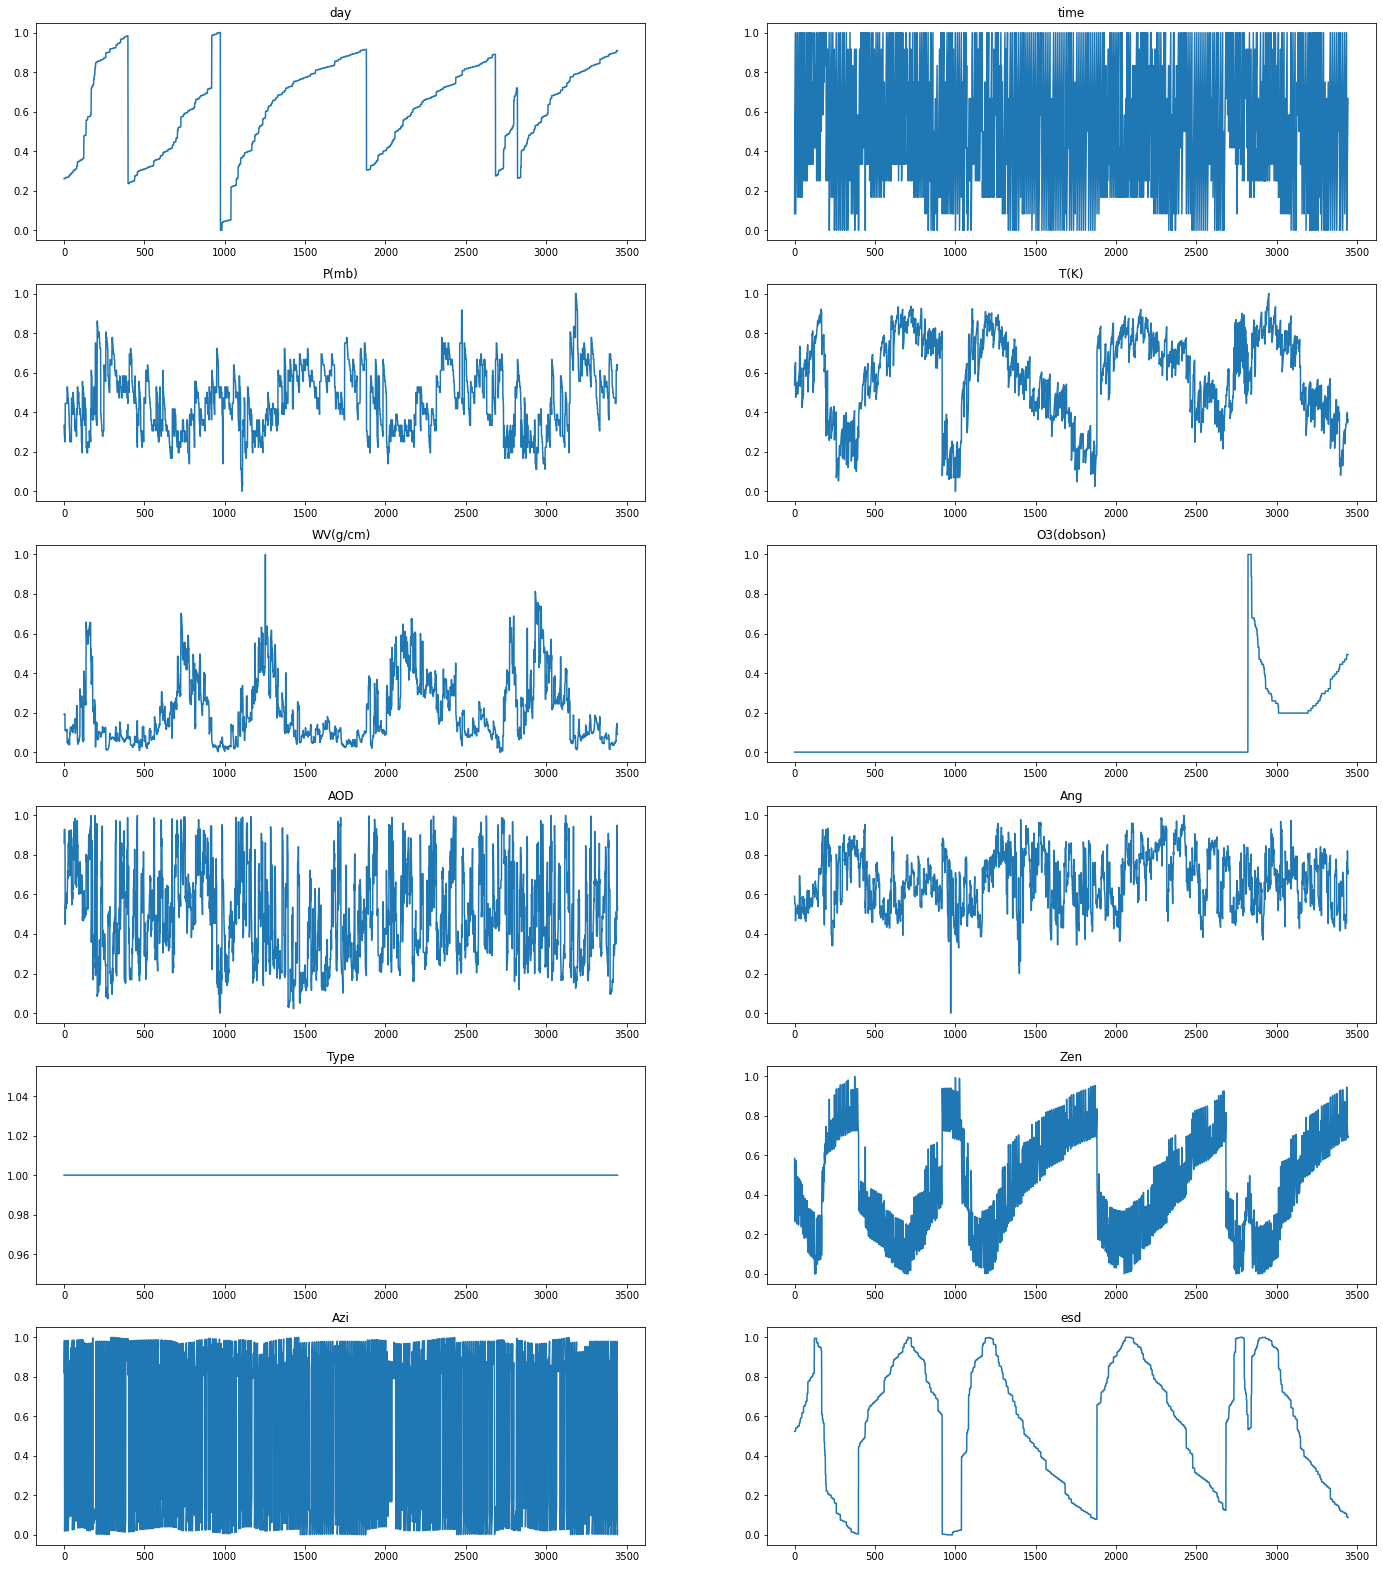

In [20]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axs.ravel()):
  # if i==11:
  #   break
  ax.plot(params_scaled[:, i])
  ax.set_title(plot_names[i])
plt.show()

## seperate test & train

In [21]:
X = np.concatenate([params_scaled, input_data], axis=1)
# X = np.concatenate([params_data, input_data], axis=1)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, output_data, test_size=0.3, random_state=9)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3445, 222)
(2411, 222) (1034, 222)
(2411, 210) (1034, 210)


## fc-net

In [ ]:
fc_net = Sequential()
fc_net.add(Dense(210, activation='relu', input_shape=(222, )))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(12, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(210, activation='linear'))

fc_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# fc_net.summary()

### result

In [22]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BTCN/fcn.h5'
fc_net = load_model(checkpoint_path, compile=False)
result = fc_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

33/33 [==============================] - 0s 3ms/step
mean angle:  2.3076792
mean rmse:  0.0071275914
mean r2:  0.8879001071651744


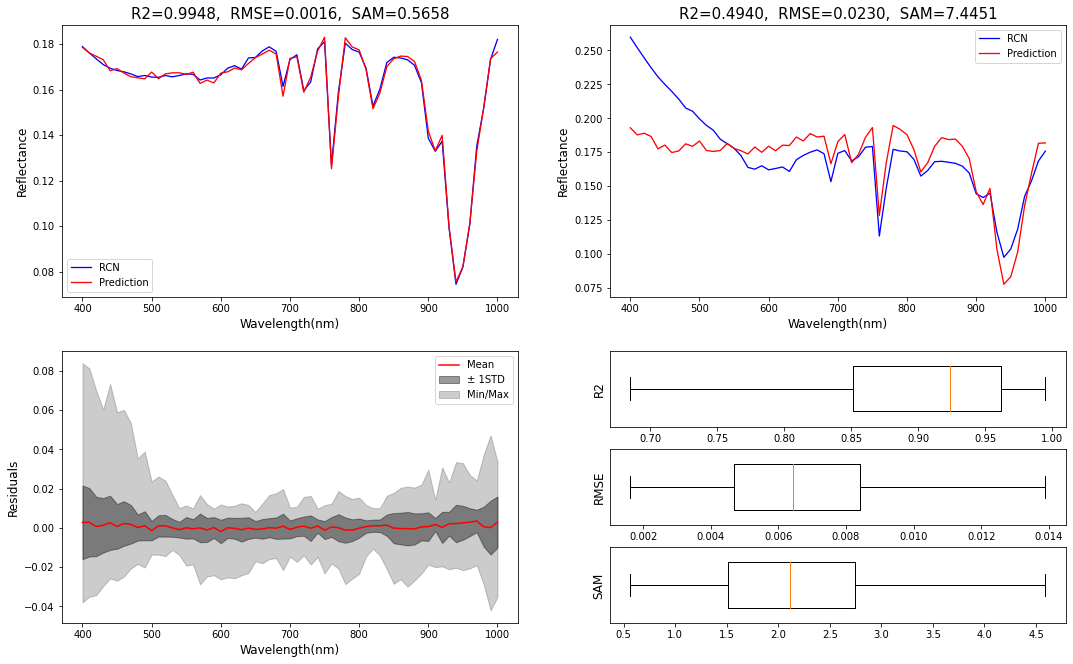

In [23]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BTCN-FC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net

In [ ]:
def build_conv_net(input_shape):
  input_1 = Input(input_shape)

  x = Conv1D(filters=8, kernel_size=3)(input_1)
  x = Activation("relu")(x)
  x = Conv1D(filters=8, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=16, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=32, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=64, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=64, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=32, kernel_size=4, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=16, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=8, kernel_size=2, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=8, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model(input_1, x)
  return model

conv_net = build_conv_net((222, 1))
conv_net.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
# conv_net.summary()

### result

In [24]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BTCN/cnn.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

33/33 [==============================] - 2s 26ms/step
mean angle:  1.7320681
mean rmse:  0.005675045
mean r2:  0.9193293953340744


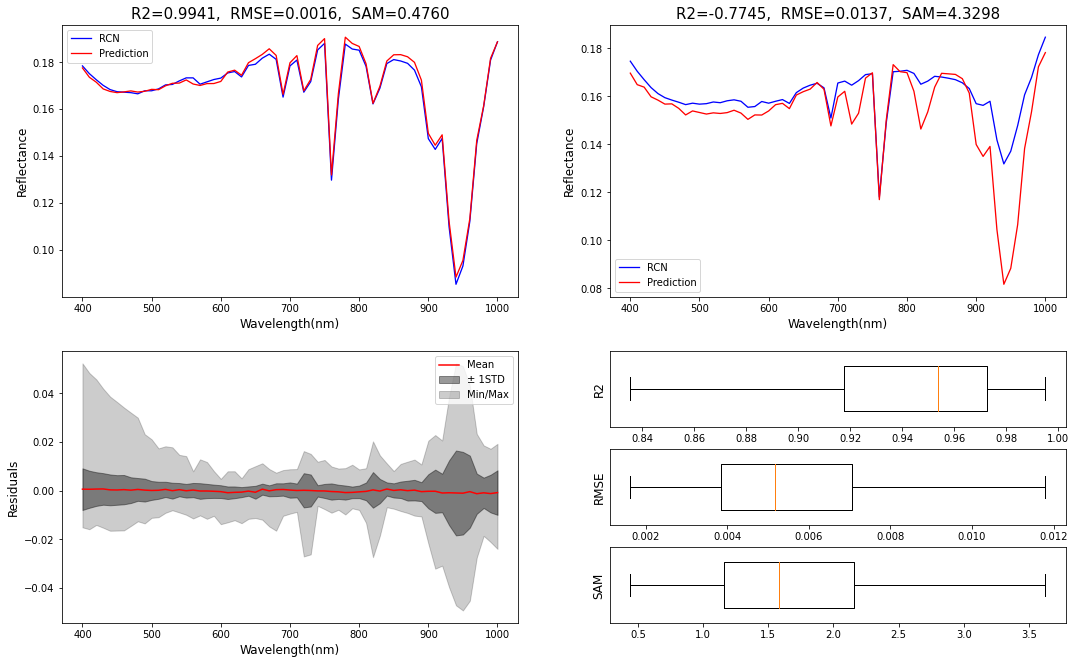

In [25]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BTCN-CNN.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net bottleneck

In [ ]:
def build_conv_net_bn(input_shape1, input_shape2):
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)

  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)

  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(input_2)
  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  x = Concatenate()([x, y])

  x = Conv1DTranspose(filters=64, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=32, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=16, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=8, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model([input_1, input_2], x)
  return model

conv_net_bn = build_conv_net_bn((210, 1), (12, 1))
conv_net_bn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
# conv_net_bn.summary()

### result

In [26]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BTCN/ae.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict([x_test[:, 12:], x_test[:, :12]])
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

33/33 [==============================] - 2s 21ms/step
mean angle:  1.3987107
mean rmse:  0.0047336747
mean r2:  0.9475555343340051


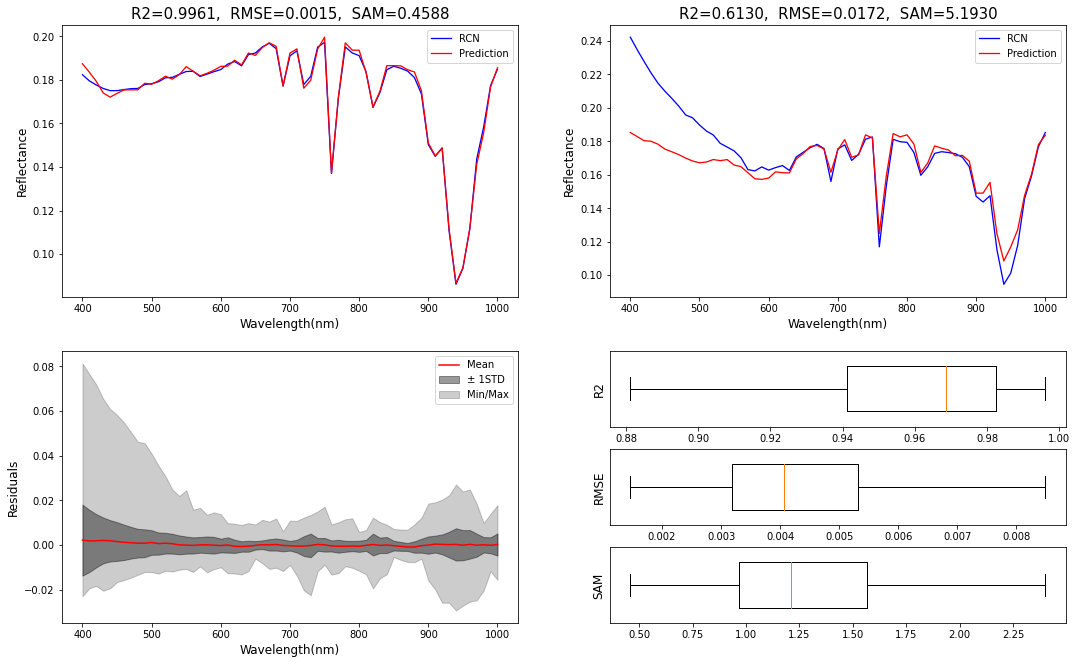

In [27]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BTCN-AE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## random forest

### result

In [34]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/BTCN/rf.pkl'
with open(checkpoint_path, 'rb') as pickle_file:
  rf = pickle.load(pickle_file)

result = rf.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, :61], result[:, :61])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

mean angle:  2.1443477556137207
mean rmse:  0.007755062954174848
mean r2:  0.8508130602707183


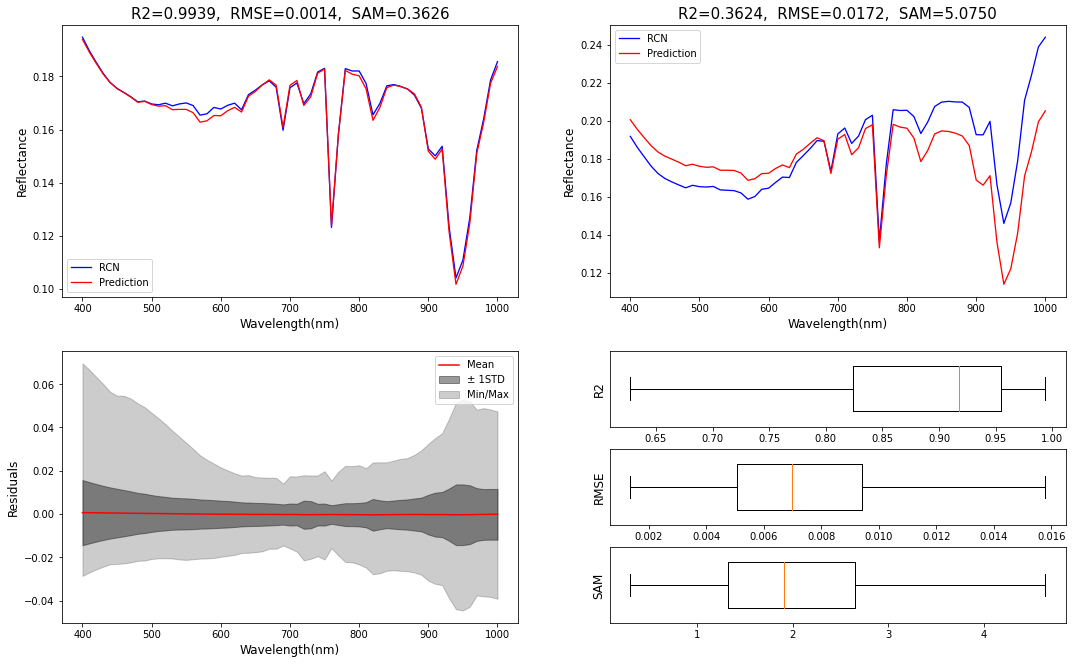

In [35]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[32]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:61], y_test[ind, :61], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:61], result[ind, :61], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:61], resi_mean[:61], 'r-', label='Mean')
ax3.fill_between(bands[:61], (resi_mean-resi_std)[:61], (resi_mean+resi_std)[:61], color='k', alpha=0.4)
ax3.fill_between(bands[:61], resi_min[:61], resi_max[:61], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/BTCN-RF.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# GONA

## load data

In [36]:
input_data = np.load('/content/gdrive/MyDrive/thesis/data/GONA_input_data.npy')
output_data = np.load('/content/gdrive/MyDrive/thesis/data/GONA_output_data.npy')
params_data = np.load('/content/gdrive/MyDrive/thesis/data/GONA_params_data.npy')

In [37]:
print(input_data.shape, output_data.shape, params_data.shape)
print(input_data.min(), output_data.min())
print(input_data.max(), output_data.max())

(13385, 181) (13385, 181) (13385, 12)
0.076 0.0003
0.611 0.5916


In [38]:
input_data = np.zeros((13385, 210)).astype('float32')
input_data[:, list(range(0, 142))+list(range(152, 191))] = np.load('/content/gdrive/MyDrive/thesis/data/GONA_input_data.npy')

output_data = np.zeros((13385, 210)).astype('float32')
output_data[:, list(range(0, 142))+list(range(152, 191))] = np.load('/content/gdrive/MyDrive/thesis/data/GONA_output_data.npy')

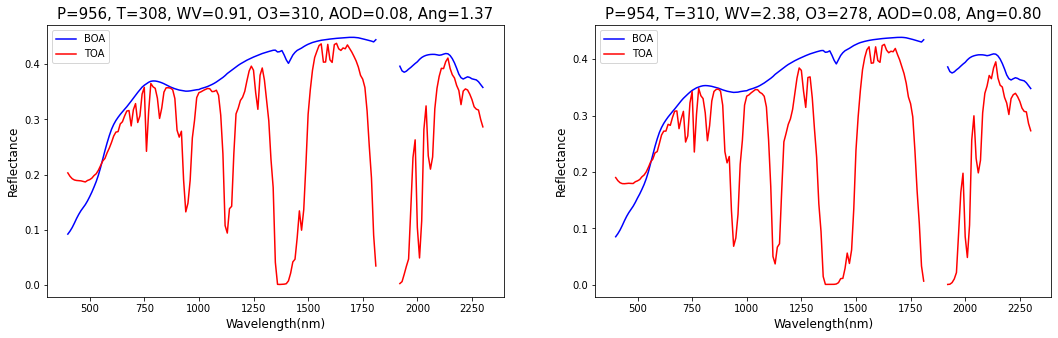

In [39]:
bands = np.arange(400, 2310, 10)
inds = np.random.randint(input_data.shape[0], size=2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
for ind, ax in zip(inds, axs.ravel()):
  ax.plot(bands[:142], input_data[ind, :142], 'b-', label='BOA')
  ax.plot(bands[:142], output_data[ind, :142], '-', color='red', label='TOA')
  ax.plot(bands[152:191], input_data[ind, 152:191], 'b-', label='BOA') 
  ax.plot(bands[152:191], output_data[ind, 152:191], '-', color='red', label='TOA')
  ax.set_title('P={:.0f}, T={:.0f}, WV={:.2f}, O3={:.0f}, AOD={:.2f}, Ang={:.2f}'.format(params_data[ind, 2], params_data[ind, 3], params_data[ind, 4], params_data[ind, 5], params_data[ind, 6], params_data[ind, 7])
  , fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['BOA', 'TOA'])
plt.savefig('/content/gdrive/MyDrive/thesis/plots/GONA2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

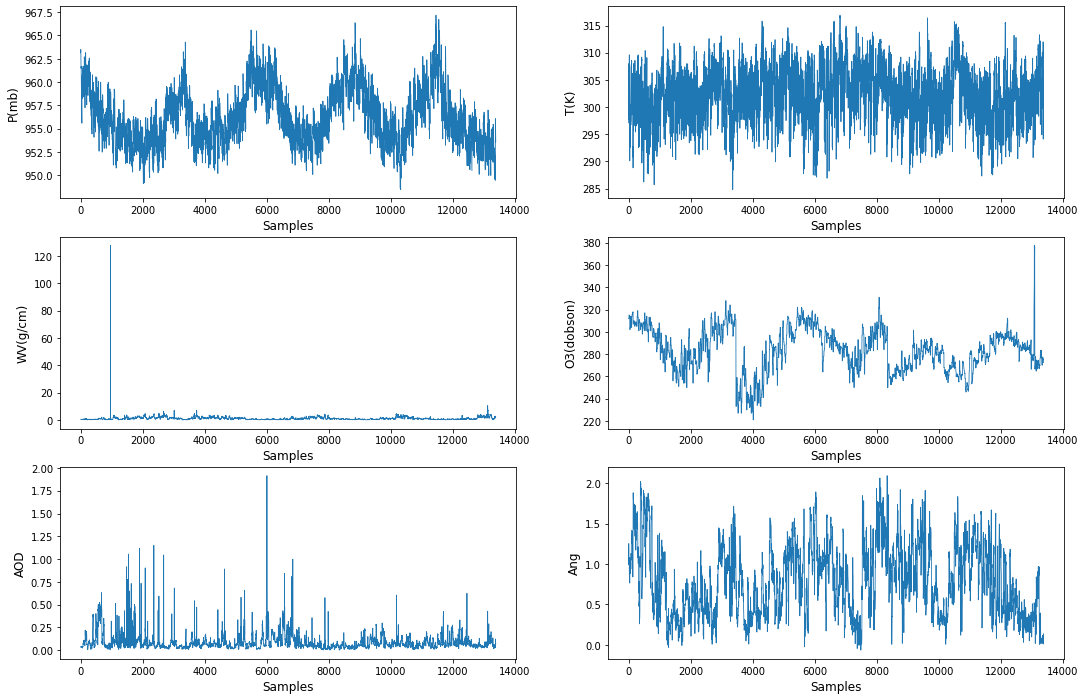

In [40]:
plot_names = ['day', 'time', 'P(mb)', 'T(K)', 'WV(g/cm)', 'O3(dobson)', 'AOD', 'Ang', 'Type', 'Zen', 'Azi', 'esd']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for i, ax in zip(range(2, 8), axs.ravel()):
  ax.plot(params_data[:, i], linewidth=0.8)
  ax.set_xlabel('Samples', fontsize=12)
  ax.set_ylabel(plot_names[i], fontsize=12)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/GONA1.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

## normalize

In [41]:
print(np.argmax(params_data[:, 4]))
print(np.argmax(params_data[:, 5]))
print(np.argmax(params_data[:, 6]))

961
13085
6005


In [42]:
params_data = np.delete(params_data, [961, 6005]+list(range(13085, 13098)), axis=0)
input_data = np.delete(input_data, [961, 6005]+list(range(13085, 13098)), axis=0)
output_data = np.delete(output_data, [961, 6005]+list(range(13085, 13098)), axis=0)

# params_data = np.delete(params_data, 8, axis=1)
# plot_names.pop(8)
params_data[0, 8] = 0
params_data[1:, 8] = 1

params_min = params_data.min(axis=0)
params_max = params_data.max(axis=0)
params_scaled = (params_data - params_min) / (params_max - params_min)

params_scaled[0, 8] = 1

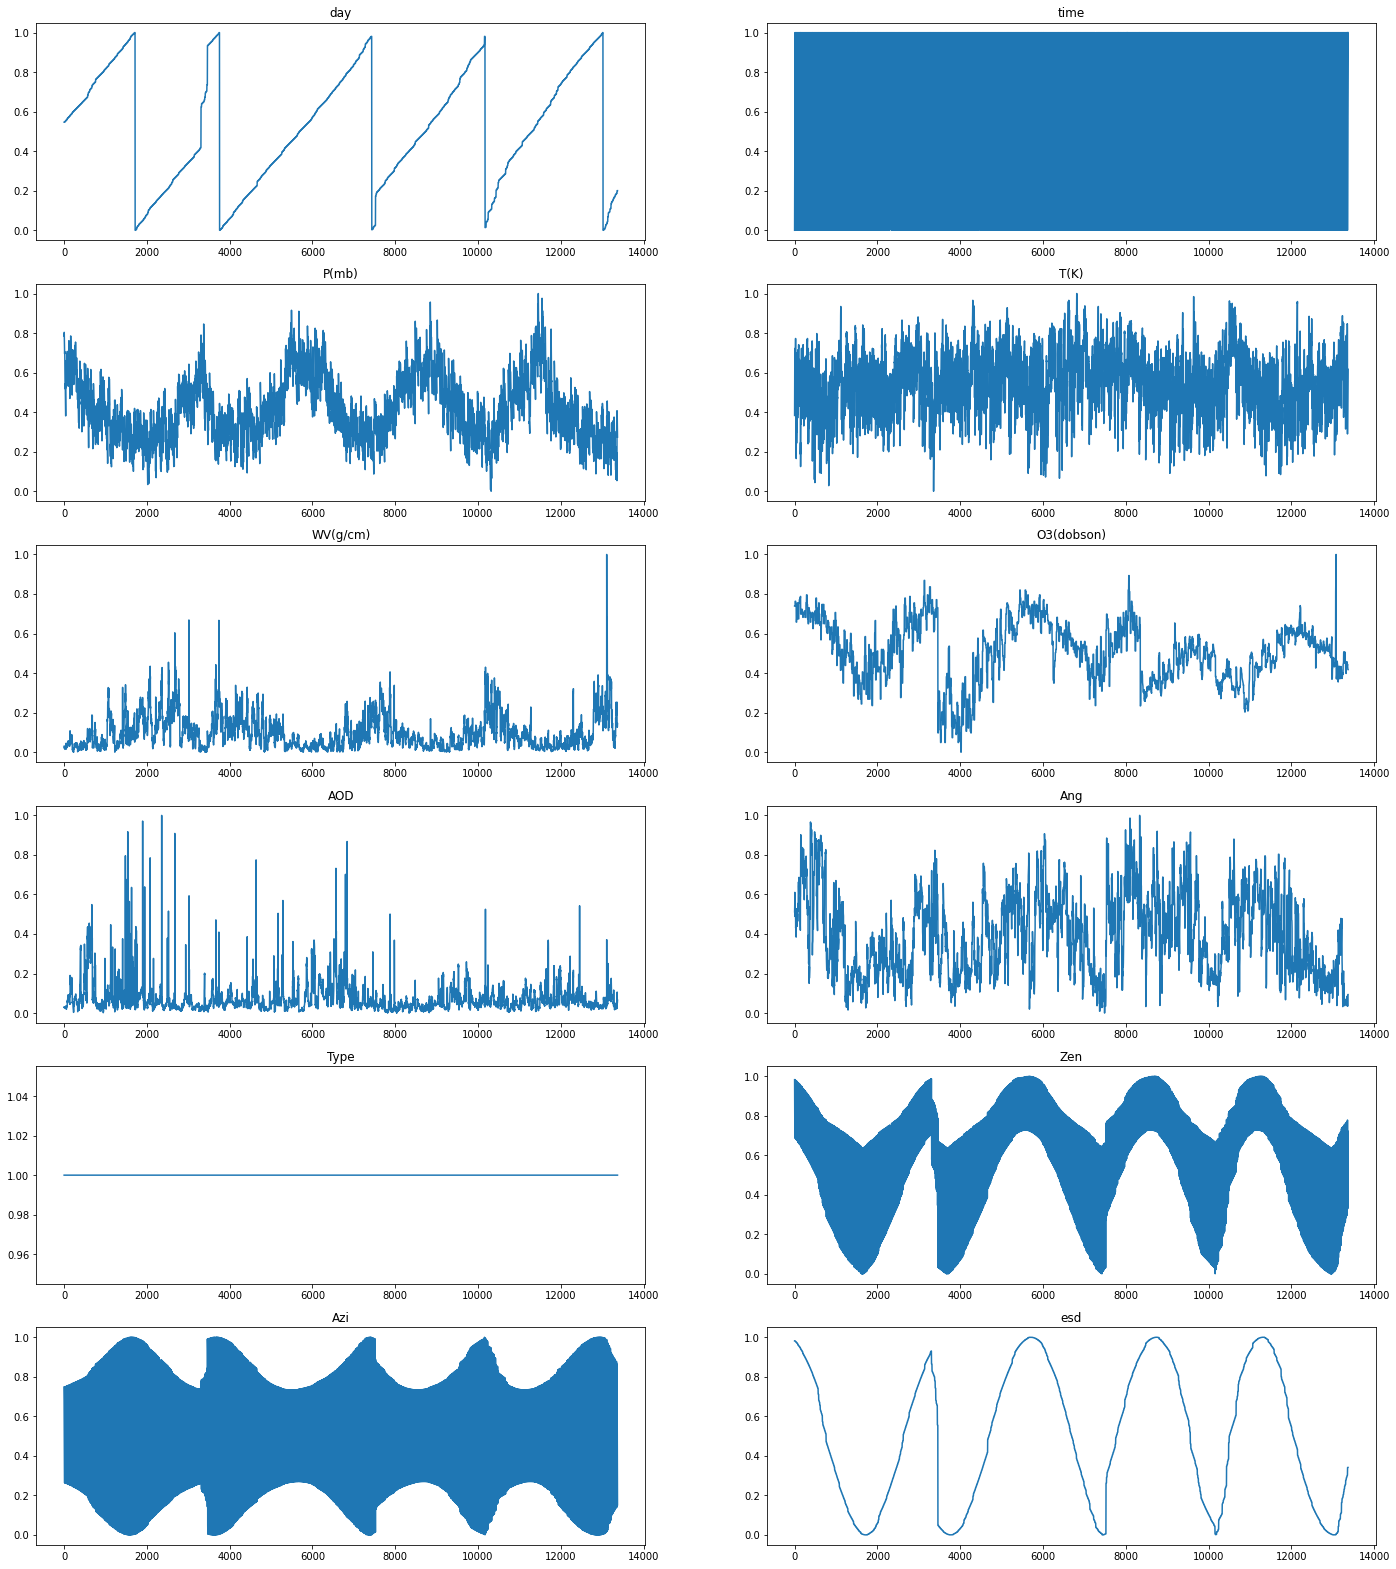

In [43]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axs.ravel()):
  # if i==11:
  #   break
  ax.plot(params_scaled[:, i])
  ax.set_title(plot_names[i])
plt.show()

## seperate test & train

In [44]:
X = np.concatenate([params_scaled, input_data], axis=1)
# X = np.concatenate([params_data, input_data], axis=1)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, output_data, test_size=0.3, random_state=9)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(13370, 222)
(9359, 222) (4011, 222)
(9359, 210) (4011, 210)


## fc-net

In [ ]:
fc_net = Sequential()
fc_net.add(Dense(210, activation='relu', input_shape=(222, )))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(12, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(210, activation='linear'))

fc_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# fc_net.summary()

### result

In [60]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/GONA/fcn.h5'
fc_net = load_model(checkpoint_path, compile=False)
result = fc_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 142))+list(range(152, 191))], result[:, list(range(0, 142))+list(range(152, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

126/126 [==============================] - 1s 3ms/step
mean angle:  4.176056
mean rmse:  0.024318568
mean r2:  0.9332027233802263


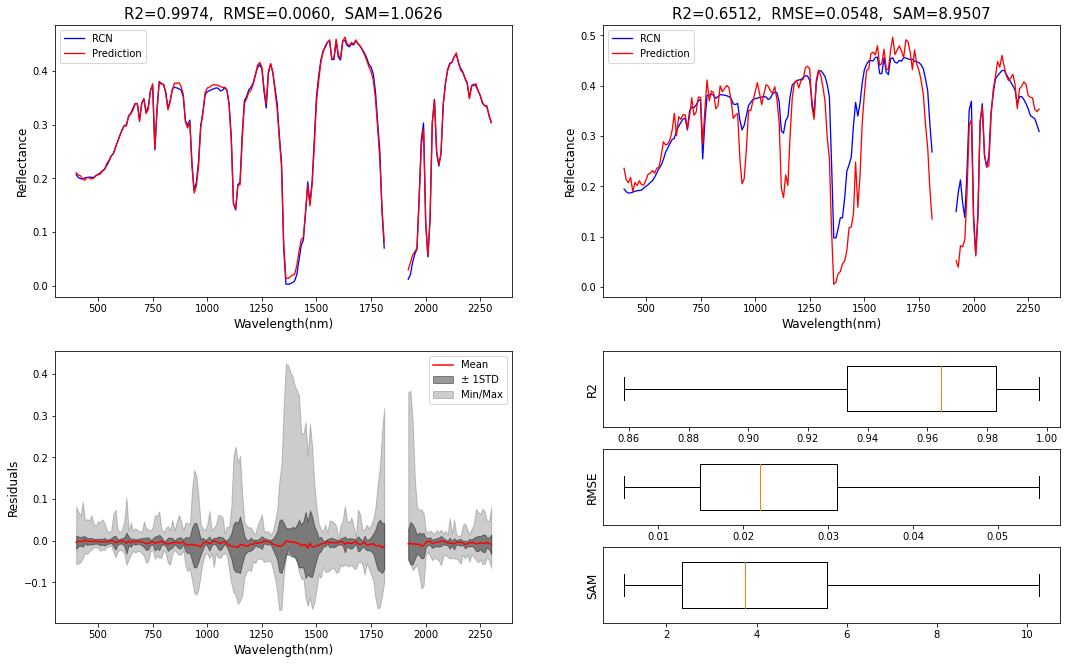

In [61]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[100]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:142], y_test[ind, :142], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:142], result[ind, :142], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[152:191], y_test[ind, 152:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[152:191], result[ind, 152:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:142], resi_mean[:142], 'r-', label='Mean')
ax3.fill_between(bands[:142], (resi_mean-resi_std)[:142], (resi_mean+resi_std)[:142], color='k', alpha=0.4)
ax3.fill_between(bands[:142], resi_min[:142], resi_max[:142], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[152:191], resi_mean[152:191], 'r-', label='Mean')
ax3.fill_between(bands[152:191], (resi_mean-resi_std)[152:191], (resi_mean+resi_std)[152:191], color='k', alpha=0.4)
ax3.fill_between(bands[152:191], resi_min[152:191], resi_max[152:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/GONA-FC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net

In [ ]:
def build_conv_net(input_shape):
  input_1 = Input(input_shape)

  x = Conv1D(filters=8*2, kernel_size=3)(input_1)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=16*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=32*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=64*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=64*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=32*2, kernel_size=4, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=16*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=8*2, kernel_size=2, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model(input_1, x)
  return model

conv_net = build_conv_net((222, 1))
conv_net.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')
# conv_net.summary()

### result

In [63]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/GONA/cnn.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 142))+list(range(152, 191))], result[:, list(range(0, 142))+list(range(152, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

126/126 [==============================] - 7s 44ms/step
mean angle:  3.3564632
mean rmse:  0.019302404
mean r2:  0.9536671653643668


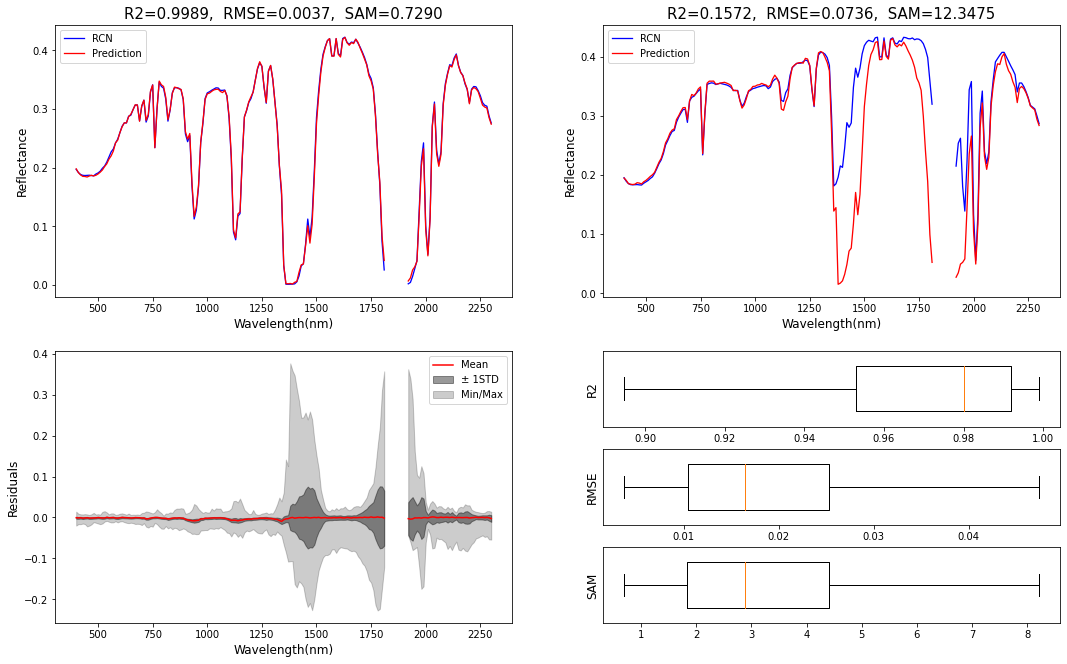

In [64]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:142], y_test[ind, :142], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:142], result[ind, :142], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[152:191], y_test[ind, 152:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[152:191], result[ind, 152:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:142], resi_mean[:142], 'r-', label='Mean')
ax3.fill_between(bands[:142], (resi_mean-resi_std)[:142], (resi_mean+resi_std)[:142], color='k', alpha=0.4)
ax3.fill_between(bands[:142], resi_min[:142], resi_max[:142], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[152:191], resi_mean[152:191], 'r-', label='Mean')
ax3.fill_between(bands[152:191], (resi_mean-resi_std)[152:191], (resi_mean+resi_std)[152:191], color='k', alpha=0.4)
ax3.fill_between(bands[152:191], resi_min[152:191], resi_max[152:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/GONA-CNN.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net bottleneck

In [ ]:
def build_conv_net_bn(input_shape1, input_shape2):
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)

  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)

  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(input_2)
  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  x = Concatenate()([x, y])

  x = Conv1DTranspose(filters=64, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=32, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=16, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=8, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model([input_1, input_2], x)
  return model

conv_net_bn = build_conv_net_bn((210, 1), (12, 1))
conv_net_bn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
# conv_net_bn.summary()

### result

In [65]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/GONA/ae.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict([x_test[:, 12:], x_test[:, :12]])
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 142))+list(range(152, 191))], result[:, list(range(0, 142))+list(range(152, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

126/126 [==============================] - 3s 21ms/step
mean angle:  1.9832547
mean rmse:  0.0116384365
mean r2:  0.9823554743621304


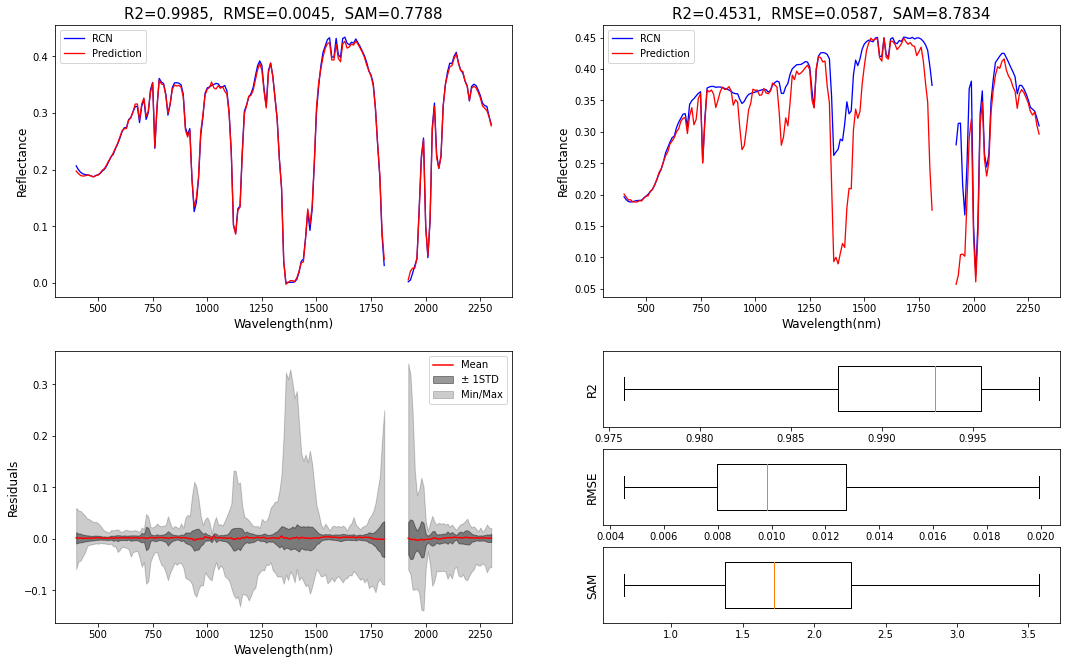

In [66]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:142], y_test[ind, :142], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:142], result[ind, :142], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[152:191], y_test[ind, 152:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[152:191], result[ind, 152:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:142], resi_mean[:142], 'r-', label='Mean')
ax3.fill_between(bands[:142], (resi_mean-resi_std)[:142], (resi_mean+resi_std)[:142], color='k', alpha=0.4)
ax3.fill_between(bands[:142], resi_min[:142], resi_max[:142], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[152:191], resi_mean[152:191], 'r-', label='Mean')
ax3.fill_between(bands[152:191], (resi_mean-resi_std)[152:191], (resi_mean+resi_std)[152:191], color='k', alpha=0.4)
ax3.fill_between(bands[152:191], resi_min[152:191], resi_max[152:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/GONA-AE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## random forest

### result

In [69]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/GONA/rf.pkl'
with open(checkpoint_path, 'rb') as pickle_file:
  rf = pickle.load(pickle_file)

result = rf.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 142))+list(range(152, 191))], result[:, list(range(0, 142))+list(range(152, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

mean angle:  2.7105949966078198
mean rmse:  0.020668620054007852
mean r2:  0.950658978100991


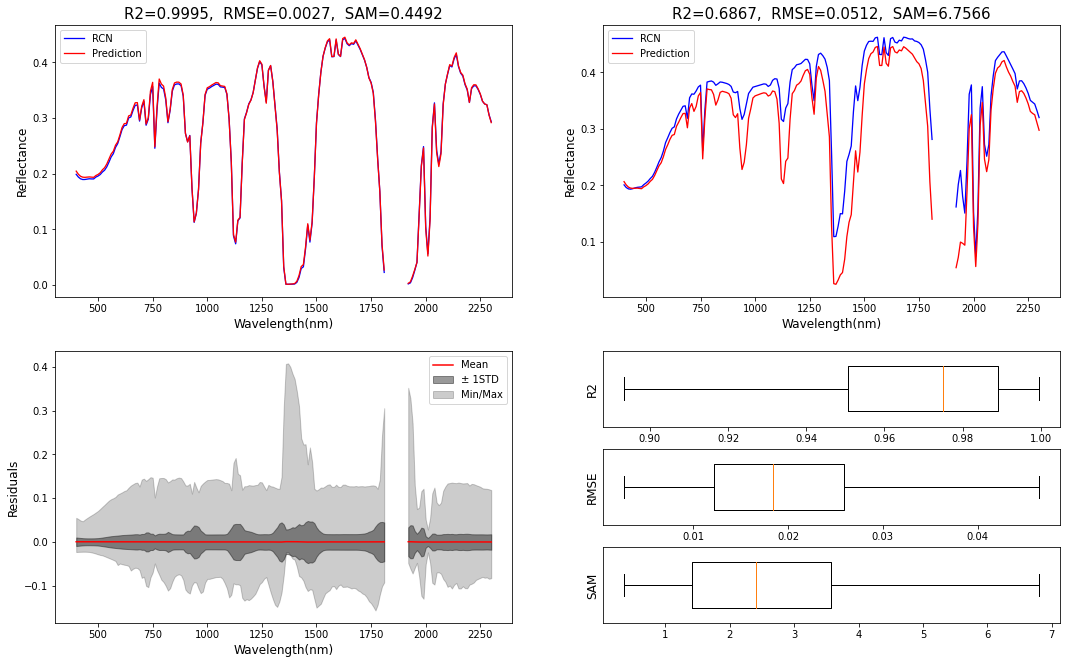

In [70]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[100]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:142], y_test[ind, :142], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:142], result[ind, :142], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[152:191], y_test[ind, 152:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[152:191], result[ind, 152:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:142], resi_mean[:142], 'r-', label='Mean')
ax3.fill_between(bands[:142], (resi_mean-resi_std)[:142], (resi_mean+resi_std)[:142], color='k', alpha=0.4)
ax3.fill_between(bands[:142], resi_min[:142], resi_max[:142], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[152:191], resi_mean[152:191], 'r-', label='Mean')
ax3.fill_between(bands[152:191], (resi_mean-resi_std)[152:191], (resi_mean+resi_std)[152:191], color='k', alpha=0.4)
ax3.fill_between(bands[152:191], resi_min[152:191], resi_max[152:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/GONA-RF.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# LCFR

## load data

In [71]:
input_data = np.load('/content/gdrive/MyDrive/thesis/data/LCFR_input_data.npy')
output_data = np.load('/content/gdrive/MyDrive/thesis/data/LCFR_output_data.npy')
params_data = np.load('/content/gdrive/MyDrive/thesis/data/LCFR_params_data.npy')

In [72]:
print(input_data.shape, output_data.shape, params_data.shape)
print(input_data.min(), output_data.min())
print(input_data.max(), output_data.max())

(11222, 185) (11222, 185) (11222, 12)
0.0 0.0004
0.4352 0.4134


In [73]:
input_data = np.zeros((11222, 210)).astype('float32')
input_data[:, list(range(0, 141))+list(range(157, 201))] = np.load('/content/gdrive/MyDrive/thesis/data/LCFR_input_data.npy')

output_data = np.zeros((11222, 210)).astype('float32')
output_data[:, list(range(0, 141))+list(range(157, 201))] = np.load('/content/gdrive/MyDrive/thesis/data/LCFR_output_data.npy')

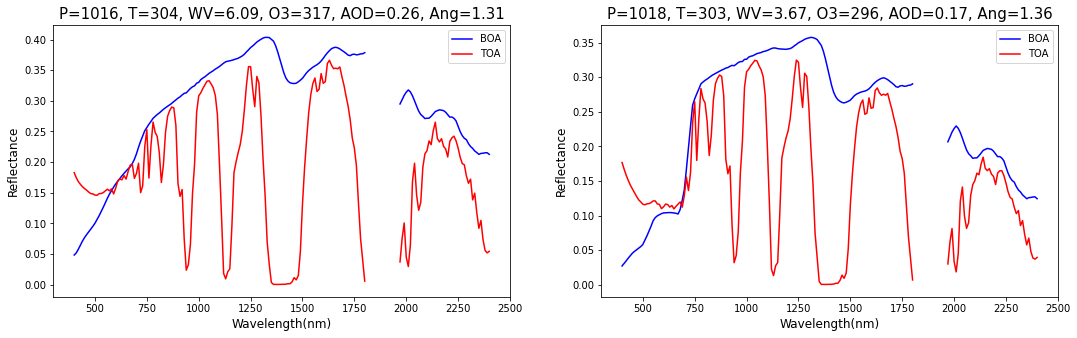

In [74]:
bands = np.arange(400, 2410, 10)
inds = np.random.randint(input_data.shape[0], size=2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
for ind, ax in zip(inds, axs.ravel()):
  ax.plot(bands[:141], input_data[ind, :141], 'b-', label='BOA')
  ax.plot(bands[:141], output_data[ind, :141], '-', color='red', label='TOA')
  ax.plot(bands[157:201], input_data[ind, 157:201], 'b-', label='BOA') 
  ax.plot(bands[157:201], output_data[ind, 157:201], '-', color='red', label='TOA')
  ax.set_title('P={:.0f}, T={:.0f}, WV={:.2f}, O3={:.0f}, AOD={:.2f}, Ang={:.2f}'.format(params_data[ind, 2], params_data[ind, 3], params_data[ind, 4], params_data[ind, 5], params_data[ind, 6], params_data[ind, 7])
  , fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['BOA', 'TOA'])
plt.savefig('/content/gdrive/MyDrive/thesis/plots/LCFR2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

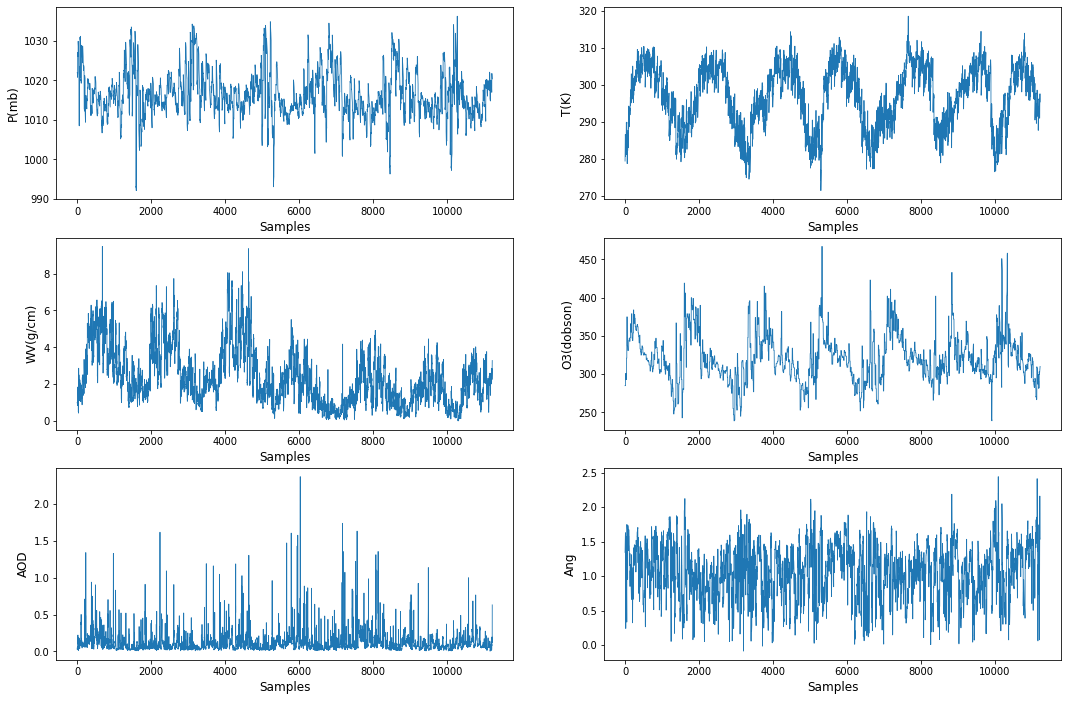

In [75]:
plot_names = ['day', 'time', 'P(mb)', 'T(K)', 'WV(g/cm)', 'O3(dobson)', 'AOD', 'Ang', 'Type', 'Zen', 'Azi', 'esd']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for i, ax in zip(range(2, 8), axs.ravel()):
  ax.plot(params_data[:, i], linewidth=0.8)
  ax.set_xlabel('Samples', fontsize=12)
  ax.set_ylabel(plot_names[i], fontsize=12)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/LCFR1.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

## normalize

In [76]:
# params_data = np.delete(params_data, [961, 6005]+list(range(13085, 13098)), axis=0)
# input_data = np.delete(input_data, [961, 6005]+list(range(13085, 13098)), axis=0)
# output_data = np.delete(output_data, [961, 6005]+list(range(13085, 13098)), axis=0)

# params_data = np.delete(params_data, 8, axis=1)
# plot_names.pop(8)
params_data[0, 8] = 0
params_data[1:, 8] = 1

params_min = params_data.min(axis=0)
params_max = params_data.max(axis=0)
params_scaled = (params_data - params_min) / (params_max - params_min)

params_scaled[0, 8] = 1

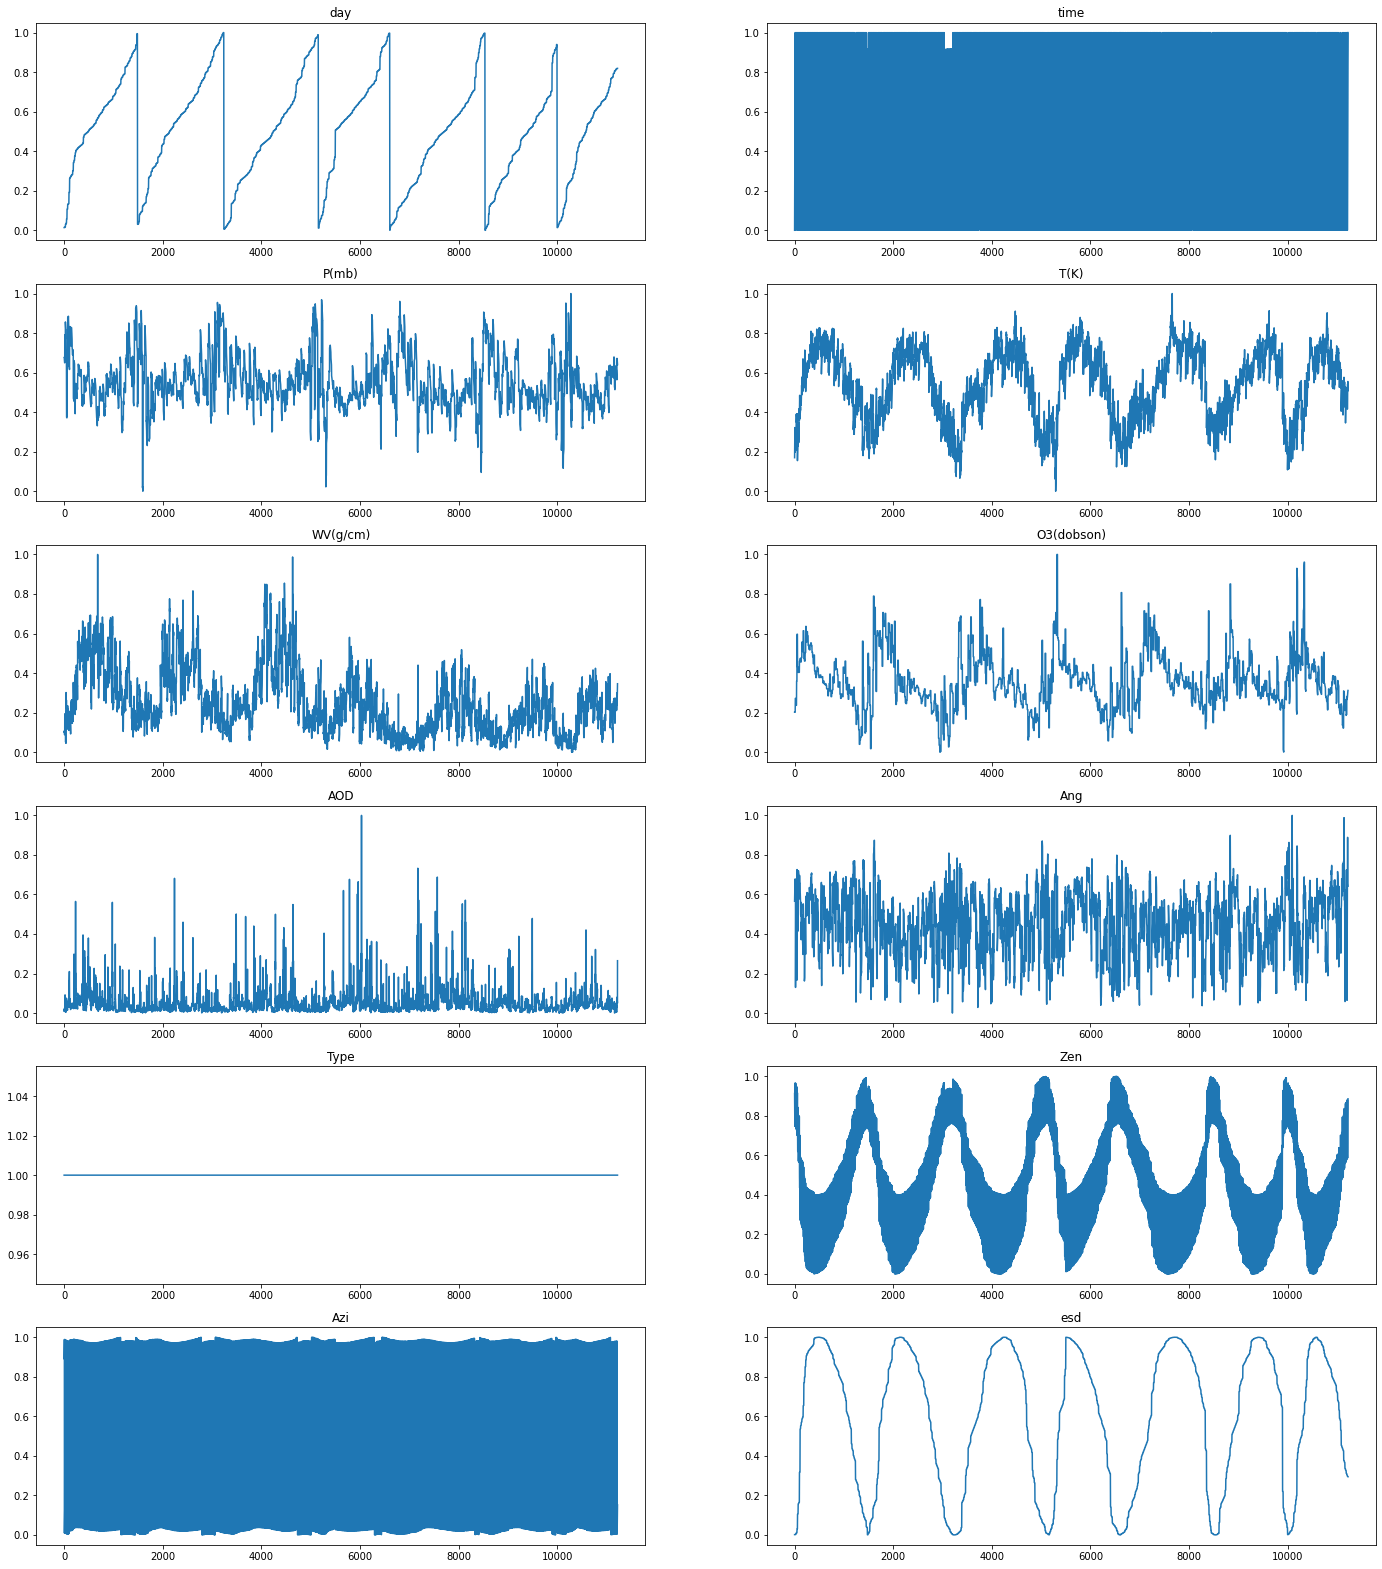

In [77]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axs.ravel()):
  # if i==11:
  #   break
  ax.plot(params_scaled[:, i])
  ax.set_title(plot_names[i])
plt.show()

## seperate test & train

In [78]:
X = np.concatenate([params_scaled, input_data], axis=1)
# X = np.concatenate([params_data, input_data], axis=1)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, output_data, test_size=0.3, random_state=9)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(11222, 222)
(7855, 222) (3367, 222)
(7855, 210) (3367, 210)


## fc-net

In [ ]:
fc_net = Sequential()
fc_net.add(Dense(210, activation='relu', input_shape=(222, )))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(12, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(210, activation='linear'))

fc_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# fc_net.summary()

### result

In [79]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/LCFR/fcn.h5'
fc_net = load_model(checkpoint_path, compile=False)
result = fc_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 201))], result[:, list(range(0, 141))+list(range(157, 201))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

106/106 [==============================] - 0s 3ms/step
mean angle:  6.4035163
mean rmse:  0.023025705
mean r2:  0.9123014943915406


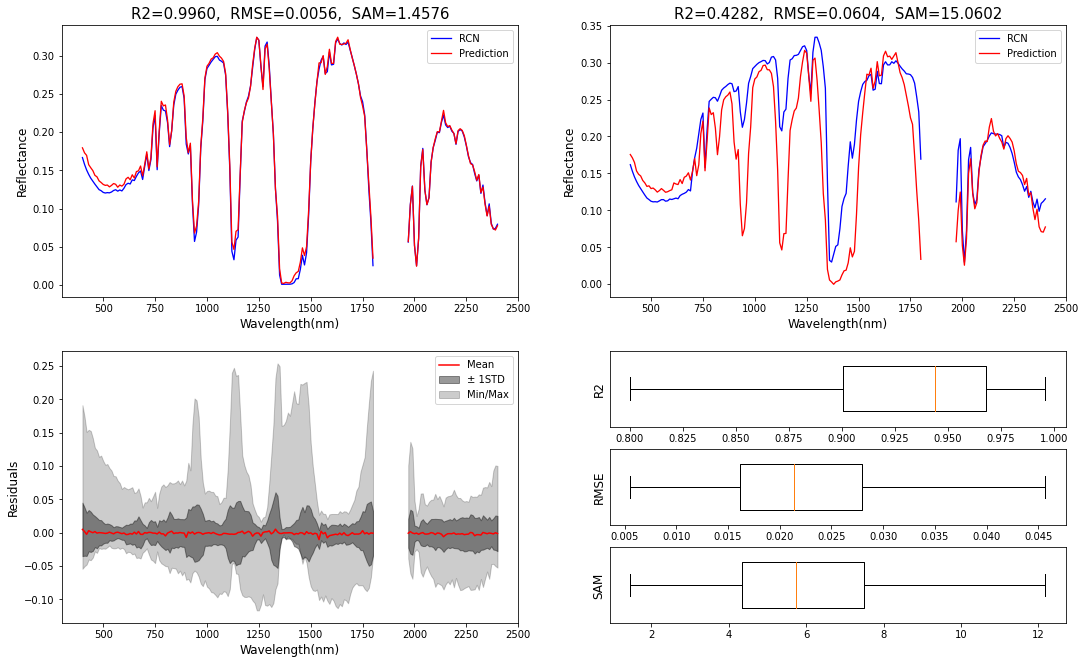

In [80]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[20]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:201], y_test[ind, 157:201], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:201], result[ind, 157:201], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:201], resi_mean[157:201], 'r-', label='Mean')
ax3.fill_between(bands[157:201], (resi_mean-resi_std)[157:201], (resi_mean+resi_std)[157:201], color='k', alpha=0.4)
ax3.fill_between(bands[157:201], resi_min[157:201], resi_max[157:201], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/LCFR-FC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net

In [ ]:
def build_conv_net(input_shape):
  input_1 = Input(input_shape)

  x = Conv1D(filters=8*2, kernel_size=3)(input_1)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=16*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=32*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=64*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=64*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=32*2, kernel_size=4, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=16*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=8*2, kernel_size=2, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model(input_1, x)
  return model

conv_net = build_conv_net((222, 1))
conv_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# conv_net.summary()

### result

In [82]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/LCFR/cnn.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 201))], result[:, list(range(0, 141))+list(range(157, 201))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

106/106 [==============================] - 5s 37ms/step
mean angle:  4.1257396
mean rmse:  0.016330149
mean r2:  0.9501809848096536


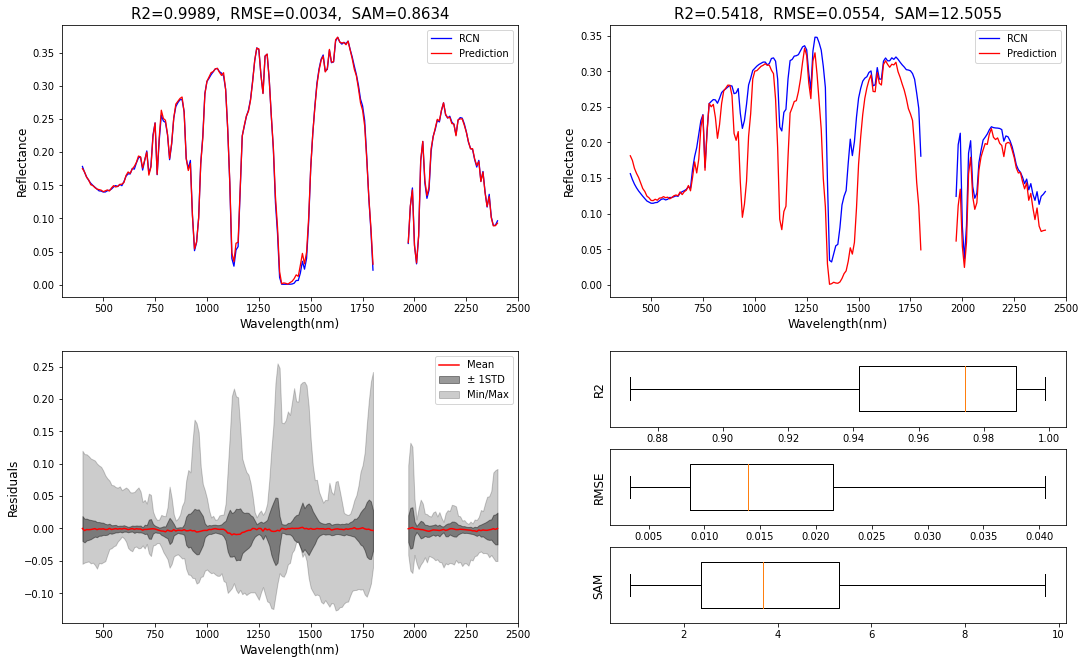

In [83]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[20]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:201], y_test[ind, 157:201], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:201], result[ind, 157:201], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:201], resi_mean[157:201], 'r-', label='Mean')
ax3.fill_between(bands[157:201], (resi_mean-resi_std)[157:201], (resi_mean+resi_std)[157:201], color='k', alpha=0.4)
ax3.fill_between(bands[157:201], resi_min[157:201], resi_max[157:201], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/LCFR-CNN.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net bottleneck

In [ ]:
def build_conv_net_bn(input_shape1, input_shape2):
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)

  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)

  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(input_2)
  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  x = Concatenate()([x, y])

  x = Conv1DTranspose(filters=64, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=32, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=16, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=8, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model([input_1, input_2], x)
  return model

conv_net_bn = build_conv_net_bn((210, 1), (12, 1))
conv_net_bn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
# conv_net_bn.summary()

### result

In [84]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/LCFR/ae.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict([x_test[:, 12:], x_test[:, :12]])
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 201))], result[:, list(range(0, 141))+list(range(157, 201))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

106/106 [==============================] - 3s 20ms/step
mean angle:  2.459574
mean rmse:  0.008752763
mean r2:  0.9855751306158012


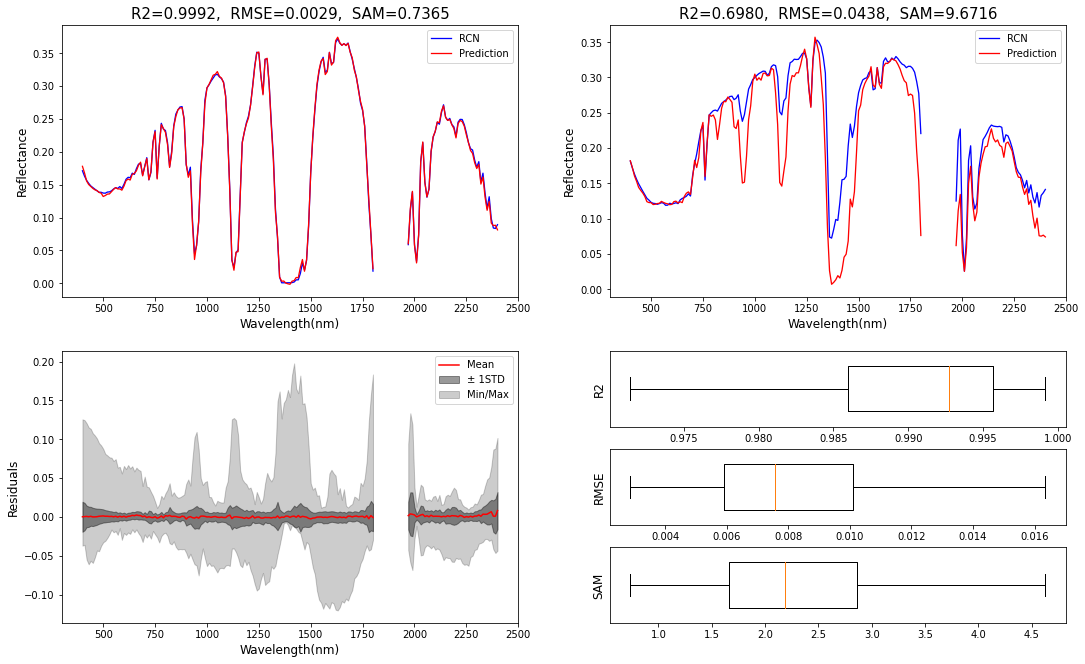

In [85]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[10]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:201], y_test[ind, 157:201], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:201], result[ind, 157:201], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:201], resi_mean[157:201], 'r-', label='Mean')
ax3.fill_between(bands[157:201], (resi_mean-resi_std)[157:201], (resi_mean+resi_std)[157:201], color='k', alpha=0.4)
ax3.fill_between(bands[157:201], resi_min[157:201], resi_max[157:201], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/LCFR-AE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## random forest

### result

In [86]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/LCFR/rf.pkl'
with open(checkpoint_path, 'rb') as pickle_file:
  rf = pickle.load(pickle_file)

result = rf.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 201))], result[:, list(range(0, 141))+list(range(157, 201))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

mean angle:  5.187527524790991
mean rmse:  0.023618188297633222
mean r2:  0.8985909808363078


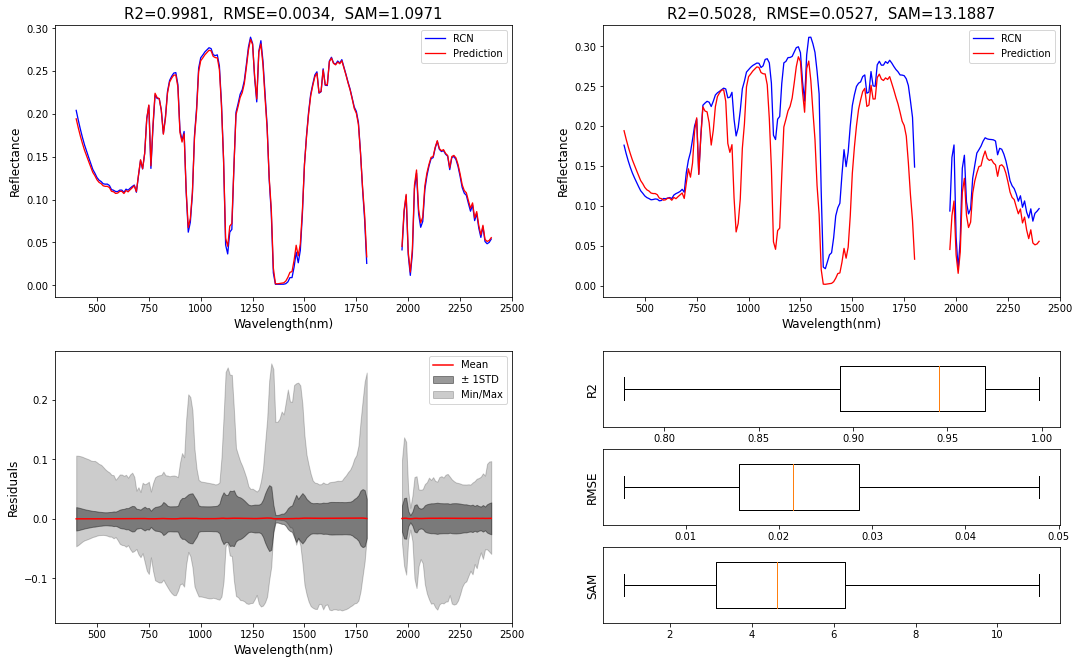

In [87]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[100]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:201], y_test[ind, 157:201], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:201], result[ind, 157:201], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:201], resi_mean[157:201], 'r-', label='Mean')
ax3.fill_between(bands[157:201], (resi_mean-resi_std)[157:201], (resi_mean+resi_std)[157:201], color='k', alpha=0.4)
ax3.fill_between(bands[157:201], resi_min[157:201], resi_max[157:201], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
# plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/LCFR-RF.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# RVUS

## load data

In [88]:
input_data = np.load('/content/gdrive/MyDrive/thesis/data/RVUS_input_data.npy')
output_data = np.load('/content/gdrive/MyDrive/thesis/data/RVUS_output_data.npy')
params_data = np.load('/content/gdrive/MyDrive/thesis/data/RVUS_params_data.npy')

In [89]:
print(input_data.shape, output_data.shape, params_data.shape)
print(input_data.min(), output_data.min())
print(input_data.max(), output_data.max())

(17348, 175) (17348, 175) (17348, 12)
0.1176 0.0005
0.5735 0.4934


In [90]:
input_data = np.zeros((17348, 210)).astype('float32')
input_data[:, list(range(0, 141))+list(range(157, 191))] = np.load('/content/gdrive/MyDrive/thesis/data/RVUS_input_data.npy')

output_data = np.zeros((17348, 210)).astype('float32')
output_data[:, list(range(0, 141))+list(range(157, 191))] = np.load('/content/gdrive/MyDrive/thesis/data/RVUS_output_data.npy')

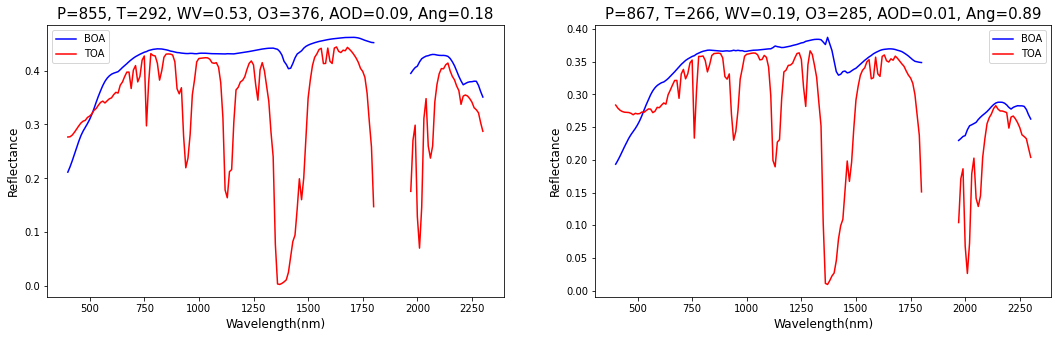

In [91]:
bands = np.arange(400, 2310, 10)
inds = np.random.randint(input_data.shape[0], size=2)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
for ind, ax in zip(inds, axs.ravel()):
  ax.plot(bands[:141], input_data[ind, :141], 'b-', label='BOA')
  ax.plot(bands[:141], output_data[ind, :141], '-', color='red', label='TOA')
  ax.plot(bands[157:191], input_data[ind, 157:191], 'b-', label='BOA') 
  ax.plot(bands[157:191], output_data[ind, 157:191], '-', color='red', label='TOA')
  ax.set_title('P={:.0f}, T={:.0f}, WV={:.2f}, O3={:.0f}, AOD={:.2f}, Ang={:.2f}'.format(params_data[ind, 2], params_data[ind, 3], params_data[ind, 4], params_data[ind, 5], params_data[ind, 6], params_data[ind, 7])
  , fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['BOA', 'TOA'])
plt.savefig('/content/gdrive/MyDrive/thesis/plots/RVUS2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

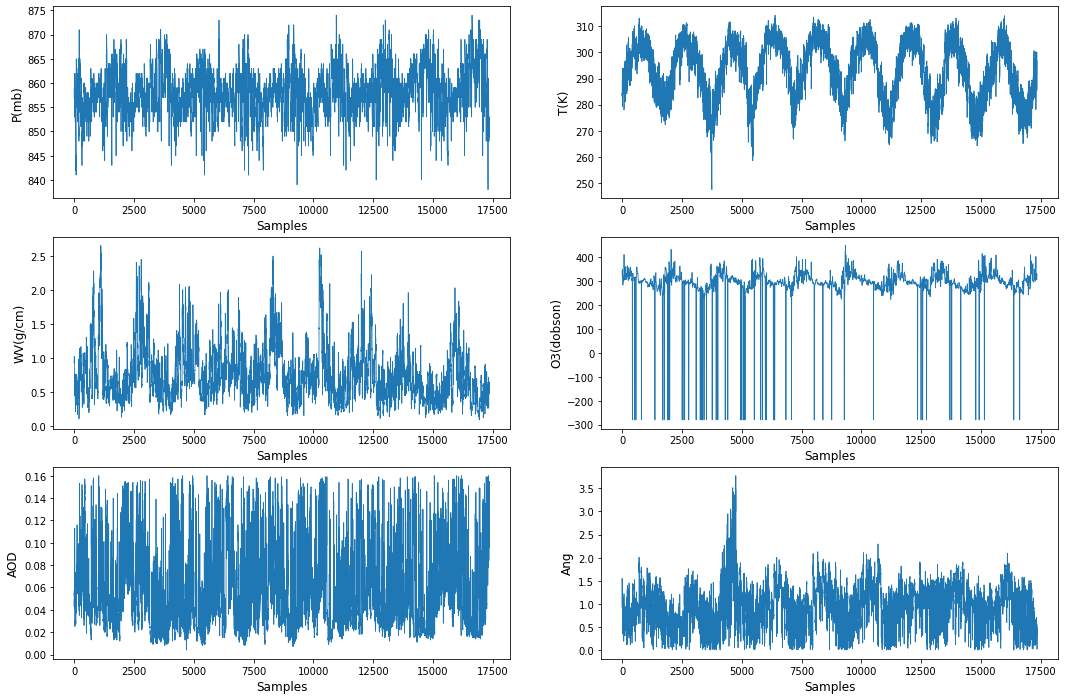

In [92]:
plot_names = ['day', 'time', 'P(mb)', 'T(K)', 'WV(g/cm)', 'O3(dobson)', 'AOD', 'Ang', 'Type', 'Zen', 'Azi', 'esd']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for i, ax in zip(range(2, 8), axs.ravel()):
  ax.plot(params_data[:, i], linewidth=0.8)
  ax.set_xlabel('Samples', fontsize=12)
  ax.set_ylabel(plot_names[i], fontsize=12)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/RVUS1.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

## normalize

In [93]:
# mask = params_data[:, 5]>0
# params_data = params_data[mask, :]
# input_data = input_data[mask, :]
# output_data = output_data[mask, :]

# mask = params_data[:, 3]>260
# params_data = params_data[mask, :]
# input_data = input_data[mask, :]
# output_data = output_data[mask, :]

# params_data = np.delete(params_data, 8, axis=1)
# plot_names.pop(8)
params_data[0, 8] = 0
params_data[1:, 8] = 1

params_min = params_data.min(axis=0)
params_max = params_data.max(axis=0)
params_scaled = (params_data - params_min) / (params_max - params_min)

params_scaled[0, 8] = 1

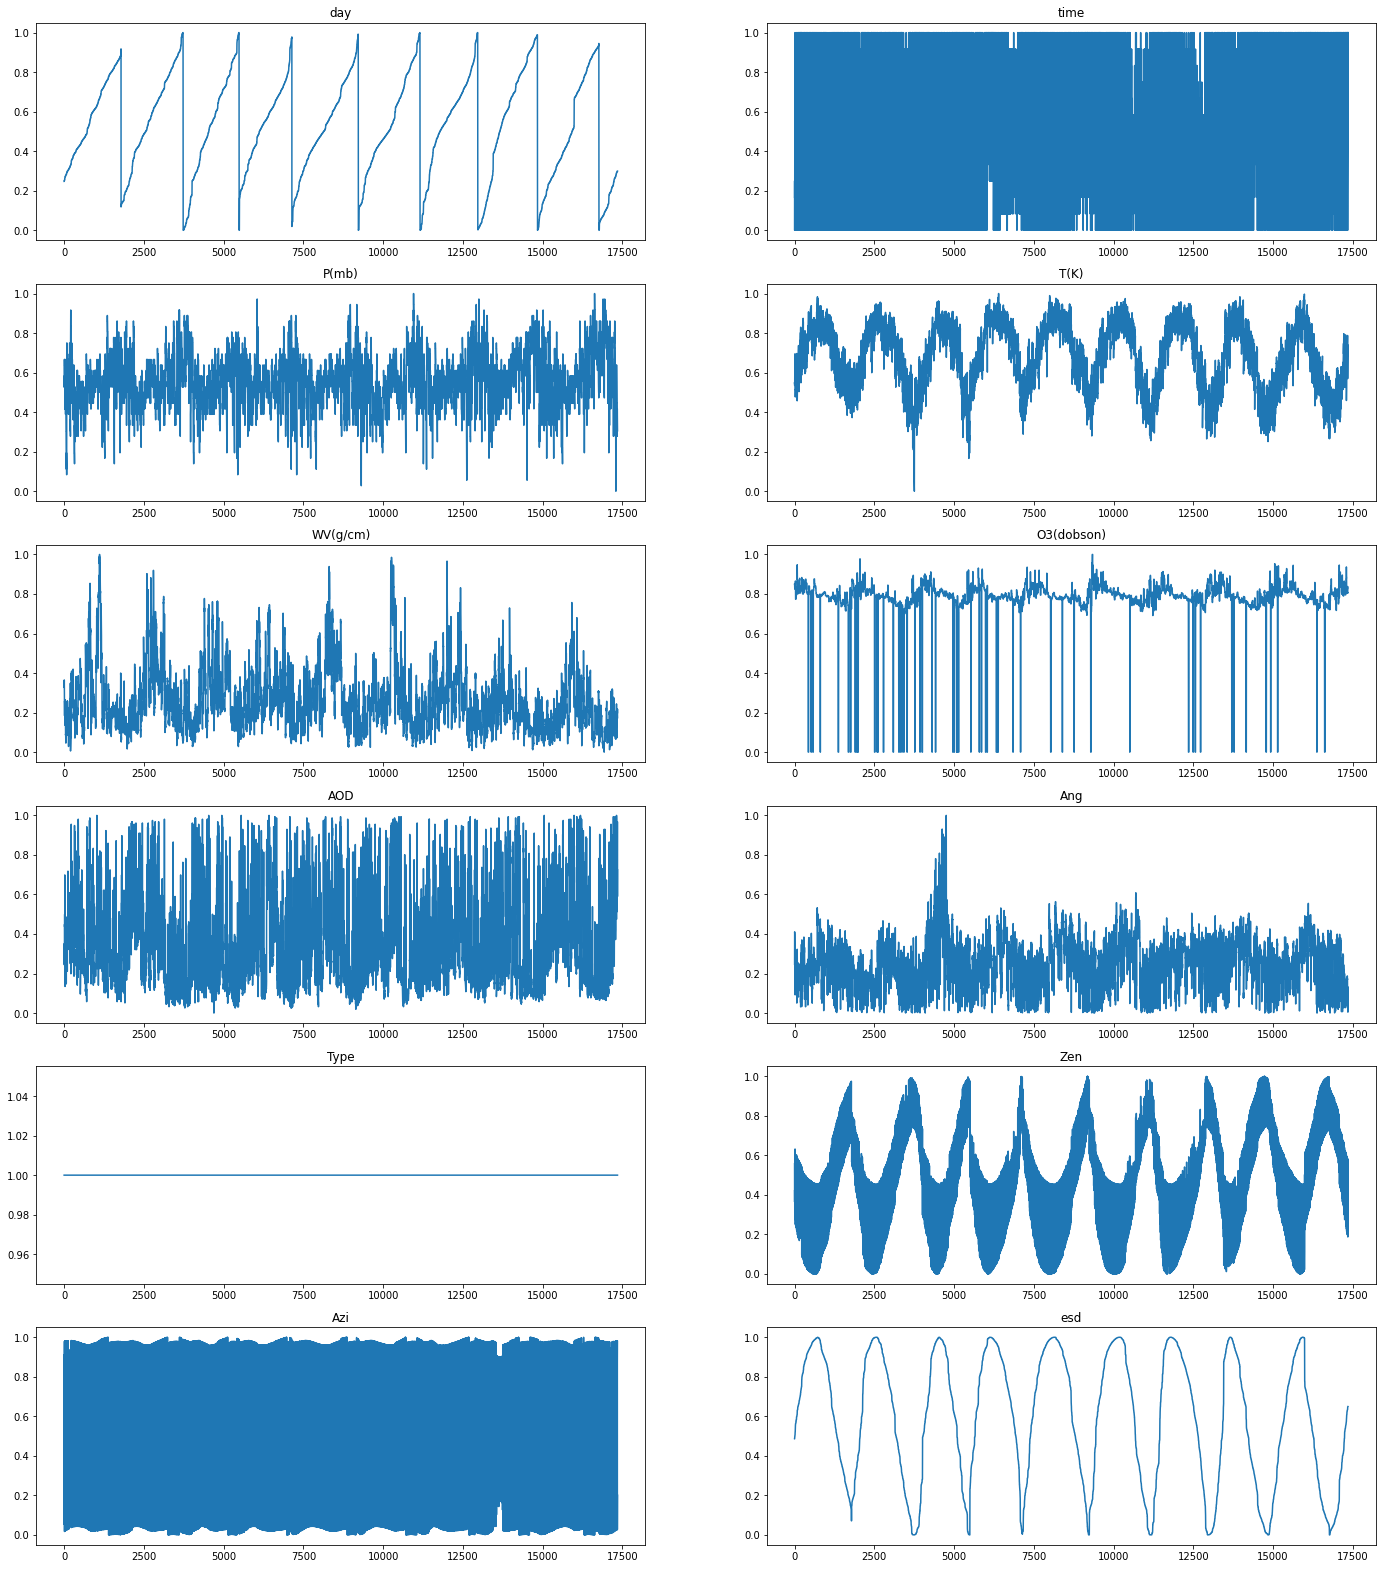

In [94]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axs.ravel()):
  # if i==11:
  #   break
  ax.plot(params_scaled[:, i])
  ax.set_title(plot_names[i])
plt.show()

## seperate test & train

In [95]:
X = np.concatenate([params_scaled, input_data], axis=1)
# X = np.concatenate([params_data, input_data], axis=1)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, output_data, test_size=0.3, random_state=9)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(17348, 222)
(12143, 222) (5205, 222)
(12143, 210) (5205, 210)


## fc-net

In [ ]:
fc_net = Sequential()
fc_net.add(Dense(210, activation='relu', input_shape=(222, )))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(12, activation='relu'))
fc_net.add(Dense(25, activation='relu'))
fc_net.add(Dense(60, activation='relu'))
fc_net.add(Dense(105, activation='relu'))
fc_net.add(Dense(210, activation='linear'))

fc_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# fc_net.summary()

### result

In [97]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/RVUS/fcn.h5'
fc_net = load_model(checkpoint_path, compile=False)
result = fc_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 191))], result[:, list(range(0, 141))+list(range(157, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

163/163 [==============================] - 1s 3ms/step
mean angle:  2.6604767
mean rmse:  0.015000135
mean r2:  0.9719048980999038


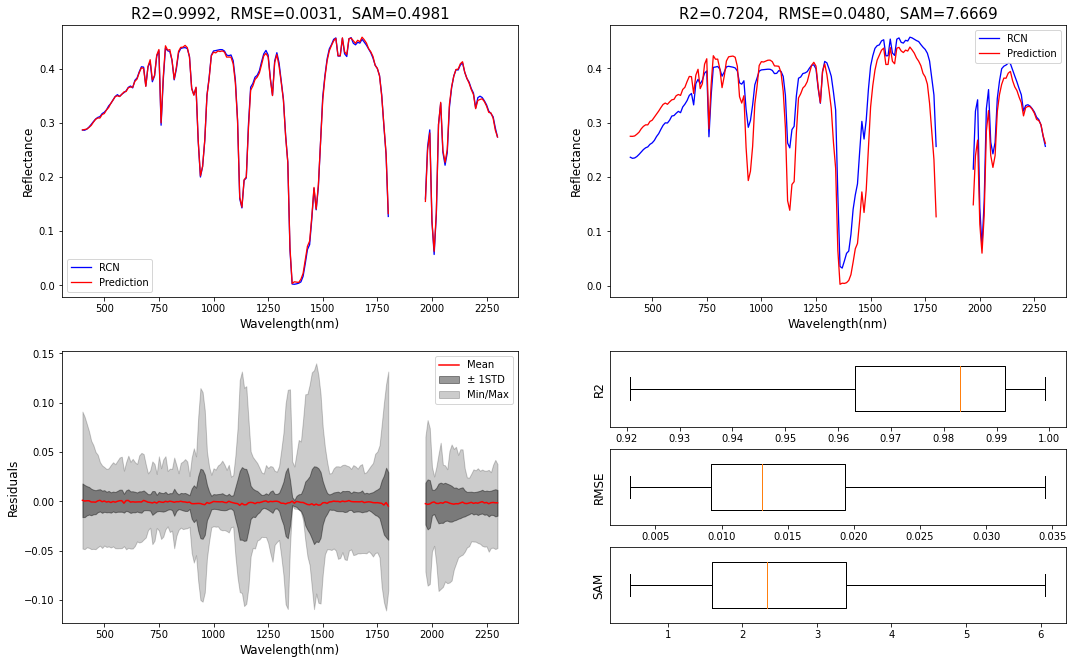

In [98]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:191], y_test[ind, 157:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:191], result[ind, 157:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:191], resi_mean[157:191], 'r-', label='Mean')
ax3.fill_between(bands[157:191], (resi_mean-resi_std)[157:191], (resi_mean+resi_std)[157:191], color='k', alpha=0.4)
ax3.fill_between(bands[157:191], resi_min[157:191], resi_max[157:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/RVUS-FC.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net

In [ ]:
def build_conv_net(input_shape):
  input_1 = Input(input_shape)

  x = Conv1D(filters=8*2, kernel_size=3)(input_1)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=16*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=32*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=64*2, kernel_size=3)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=128*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=64*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=64*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=32*2, kernel_size=4, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=32*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=16*2, kernel_size=3, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=16*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1DTranspose(filters=8*2, kernel_size=2, strides=2)(x)
  x = Activation("relu")(x)
  x = Conv1D(filters=8*2, kernel_size=3, padding="same")(x)
  x = Activation("relu")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model(input_1, x)
  return model

conv_net = build_conv_net((222, 1))
conv_net.compile(optimizer=Adam(learning_rate = 0.0003), loss='mean_squared_error')
# conv_net.summary()

### result

In [100]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/RVUS/cnn.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 191))], result[:, list(range(0, 141))+list(range(157, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

163/163 [==============================] - 12s 59ms/step
mean angle:  2.3004498
mean rmse:  0.015057427
mean r2:  0.9711672101843488


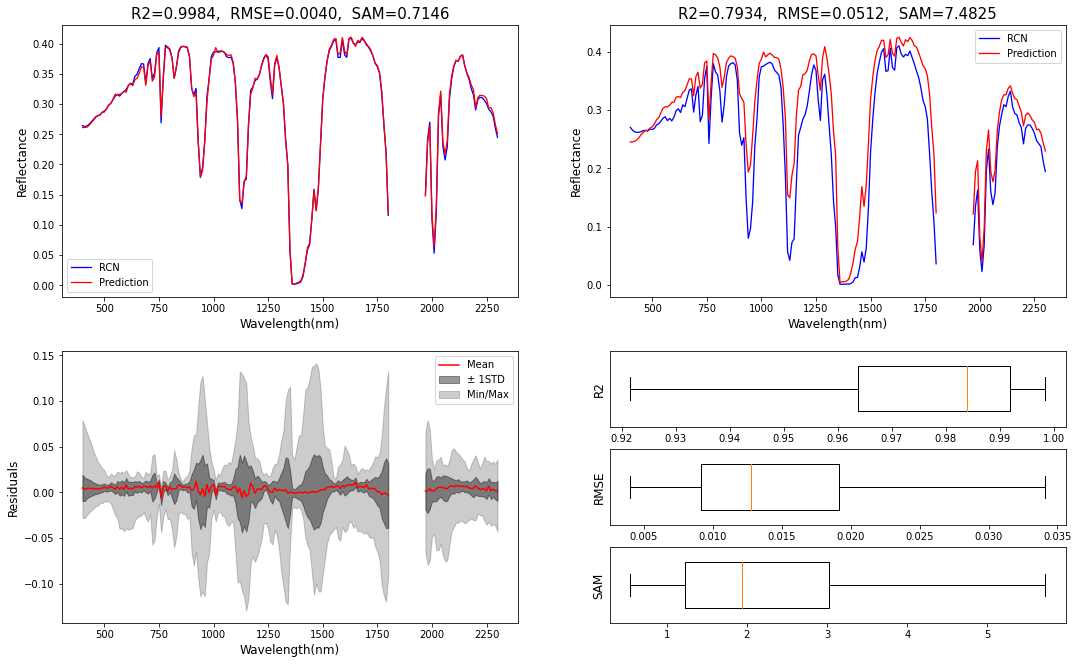

In [101]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:191], y_test[ind, 157:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:191], result[ind, 157:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:191], resi_mean[157:191], 'r-', label='Mean')
ax3.fill_between(bands[157:191], (resi_mean-resi_std)[157:191], (resi_mean+resi_std)[157:191], color='k', alpha=0.4)
ax3.fill_between(bands[157:191], resi_min[157:191], resi_max[157:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/RVUS-CNN.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## conv-net bottleneck

In [ ]:
def build_conv_net_bn(input_shape1, input_shape2):
  input_1 = Input(input_shape1)
  input_2 = Input(input_shape2)

  x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_1)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = MaxPool1D(2)(x)

  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1D(filters=128, kernel_size=3, activation='relu', padding="same")(x)

  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(input_2)
  y = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  y = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(y)
  x = Concatenate()([x, y])

  x = Conv1DTranspose(filters=64, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=32, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=32, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=16, kernel_size=2, strides=2, activation='relu')(x)
  x = Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
  x = Conv1DTranspose(filters=8, kernel_size=4, strides=2, activation='relu')(x)
  x = Conv1D(filters=8, kernel_size=3, activation='relu', padding="same")(x)

  x = Conv1D(filters=1, kernel_size=3, activation='linear', padding="same")(x)

  model = Model([input_1, input_2], x)
  return model

conv_net_bn = build_conv_net_bn((210, 1), (12, 1))
conv_net_bn.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error')
# conv_net_bn.summary()

### result

In [109]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/RVUS/ae.h5'
conv_net = load_model(checkpoint_path, compile=False)
result = conv_net.predict([x_test[:, 12:], x_test[:, :12]])
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 191))], result[:, list(range(0, 141))+list(range(157, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

163/163 [==============================] - 9s 30ms/step
mean angle:  1.4294652
mean rmse:  0.0087028295
mean r2:  0.9906438851646585


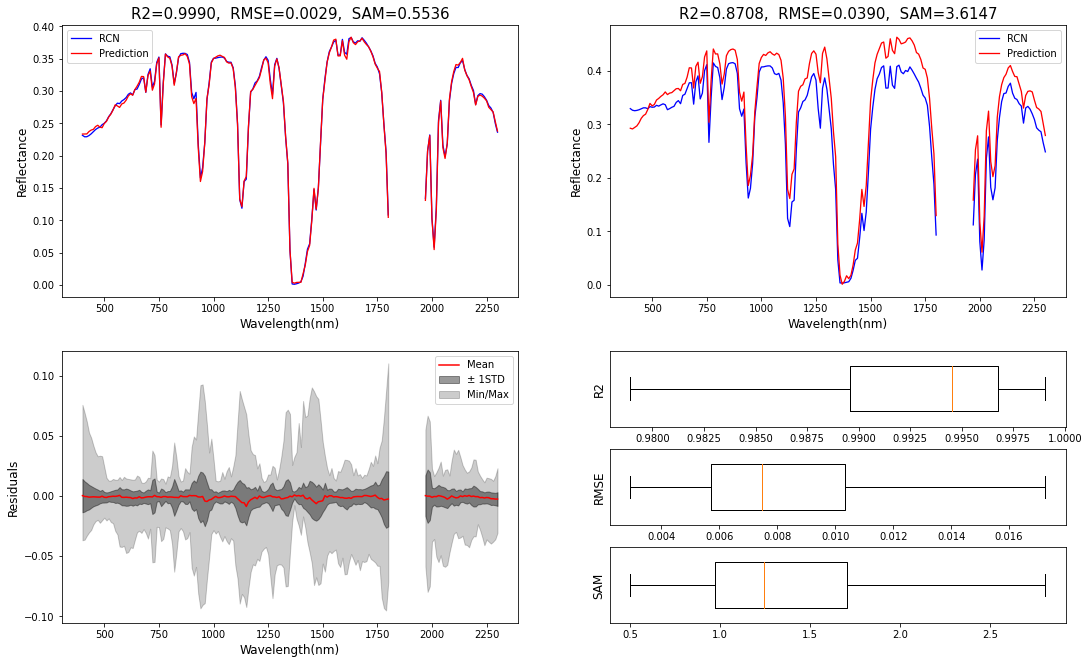

In [110]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result[:, :, 0]
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:191], y_test[ind, 157:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:191], result[ind, 157:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind, 0]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:191], resi_mean[157:191], 'r-', label='Mean')
ax3.fill_between(bands[157:191], (resi_mean-resi_std)[157:191], (resi_mean+resi_std)[157:191], color='k', alpha=0.4)
ax3.fill_between(bands[157:191], resi_min[157:191], resi_max[157:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/RVUS-AE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## random forest

### result

In [113]:
checkpoint_path = '/content/gdrive/MyDrive/thesis/final/models/RVUS/rf.pkl'
with open(checkpoint_path, 'rb') as pickle_file:
  rf = pickle.load(pickle_file)

result = rf.predict(x_test)
angles, rmse, r2 = calc_metrics(y_test[:, list(range(0, 141))+list(range(157, 191))], result[:, list(range(0, 141))+list(range(157, 191))])
print('mean angle: ', np.mean(angles))
print('mean rmse: ', np.mean(rmse))
print('mean r2: ', np.mean(r2))

mean angle:  2.6254103672361486
mean rmse:  0.02120270684592543
mean r2:  0.9468988379248517


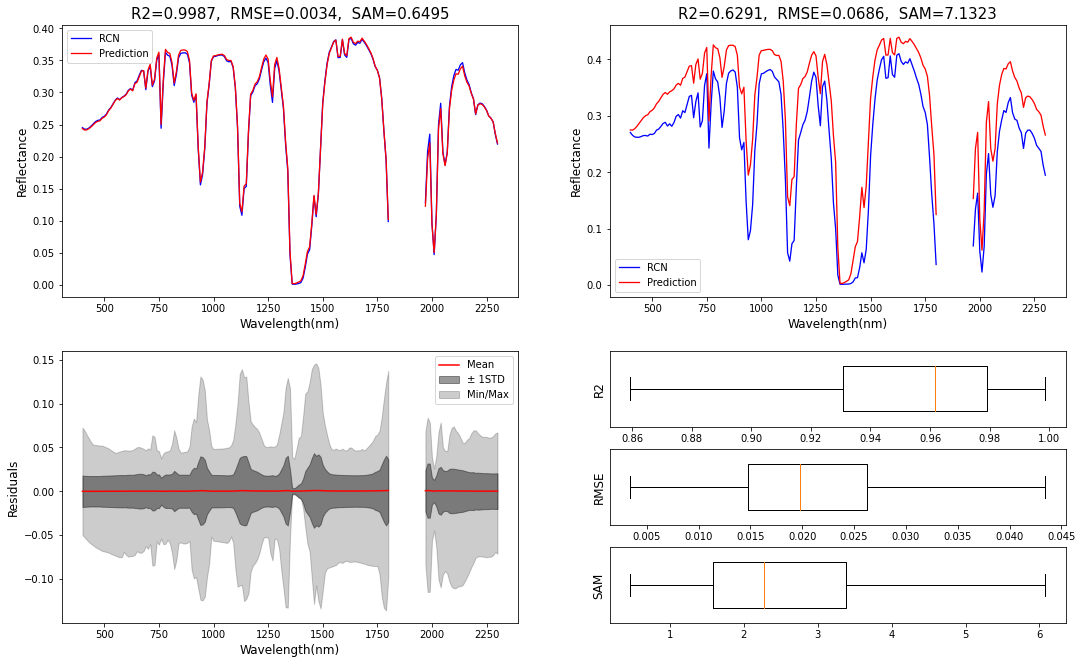

In [114]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

resi = y_test-result
resi_min = resi.min(axis=0)
resi_max = resi.max(axis=0)
resi_mean = resi.mean(axis=0)
resi_std = np.std(resi, axis=0)

inds = np.argsort(rmse)[::-1]
inds = [inds[-1], inds[0]]
# inds = inds[np.random.randint(20, size=6)]
# inds = np.random.randint(400, size=6)

fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 1, figure=fig, hspace=0.2)
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[1], hspace=0.3)

ax1 = fig.add_subplot(gs1[ 0])
ax2 = fig.add_subplot(gs1[1])

ax3 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[0, 1])
ax5 = fig.add_subplot(gs2[1, 1])
ax6 = fig.add_subplot(gs2[2, 1])

for ind, ax in zip(inds, [ax1, ax2]):
  ax.plot(bands[:141], y_test[ind, :141], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[:141], result[ind, :141], 'r-', linewidth=1.3, label='Prediction')
  ax.plot(bands[157:191], y_test[ind, 157:191], 'b-', linewidth=1.3, label='RCN')
  ax.plot(bands[157:191], result[ind, 157:191], 'r-', linewidth=1.3, label='Prediction')
  ax.set_title('R2={:.4f},  RMSE={:.4f},  SAM={:.4f}'.format(r2[ind], rmse[ind], angles[ind]), fontsize=15)
  ax.set_xlabel('Wavelength(nm)', fontsize=12)
  ax.set_ylabel('Reflectance', fontsize=12)
  ax.legend(['RCN', 'Prediction'])

ax3.plot(bands[:141], resi_mean[:141], 'r-', label='Mean')
ax3.fill_between(bands[:141], (resi_mean-resi_std)[:141], (resi_mean+resi_std)[:141], color='k', alpha=0.4)
ax3.fill_between(bands[:141], resi_min[:141], resi_max[:141], color='k', alpha=0.2)
ax3.legend(['Mean', '\u00B1 1STD', 'Min/Max'])
ax3.plot(bands[157:191], resi_mean[157:191], 'r-', label='Mean')
ax3.fill_between(bands[157:191], (resi_mean-resi_std)[157:191], (resi_mean+resi_std)[157:191], color='k', alpha=0.4)
ax3.fill_between(bands[157:191], resi_min[157:191], resi_max[157:191], color='k', alpha=0.2)
ax3.set_xlabel('Wavelength(nm)', fontsize=12)
ax3.set_ylabel('Residuals', fontsize=12)

ax4.boxplot(r2, vert=False, showfliers=False, widths=0.6)
ax4.set_ylabel('R2', fontsize=12)
ax4.tick_params(left=False, labelleft=False)
ax5.boxplot(rmse, vert=False, showfliers=False, widths=0.6)
ax5.set_ylabel('RMSE', fontsize=12)
ax5.tick_params(left=False, labelleft=False)
ax6.boxplot(angles, vert=False, showfliers=False, widths=0.6)
ax6.set_ylabel('SAM', fontsize=12)
ax6.tick_params(left=False, labelleft=False)
plt.savefig('/content/gdrive/MyDrive/thesis/plots/results/RVUS-RF.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()